<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
#common libraries
import numpy as np
import os
import math
import random
from collections import OrderedDict

#torch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss

#to manage OFF files and transform to voxel grid
!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

#to manage with progression and time in train and evaluate phase 
import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 28.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: w

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 69.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-06-03 07:29:01--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-06-03 07:29:01--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M   122MB/s    in 5.1s    

2023-06-03 07:29:06 (89.1 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [4]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

rot = 0

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if (rot%8)==0:
              mesh = mesh
              rotat = 0
              rot +=1
            elif (rot%8)==1:
              mesh.rotate(r45)
              rotat = 1
              rot +=1
            elif (rot%8)==2:
              mesh.rotate(r90)
              rotat = 2
              rot +=1
            elif (rot%8)==3:
              mesh.rotate(r135) 
              rotat = 3 
              rot +=1
            elif (rot%8)==4:
              mesh.rotate(r180)
              rotat = 4
              rot +=1
            elif (rot%8)==5:
              mesh.rotate(r225)
              rotat = 5
              rot +=1
            elif (rot%8)==6:
              mesh.rotate(r270)
              rotat = 6
              rot+=1
            else:
              mesh.rotate(r315)
              rotat = 7
              rot+=1
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:03<00:00, 28.90it/s]


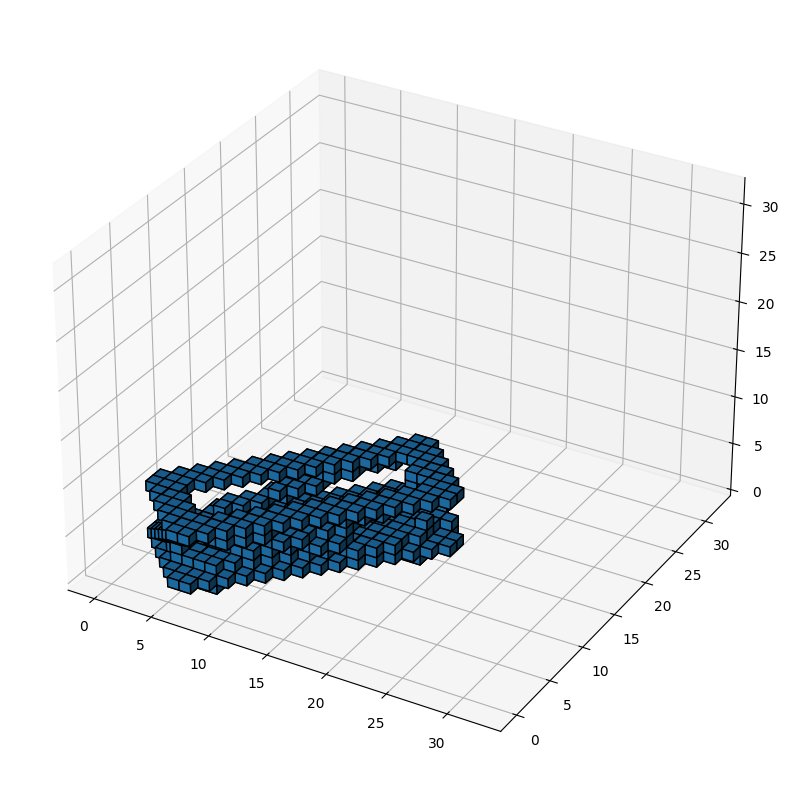

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [6]:
class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
   

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [7]:
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [15]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
62.359375


Train loss: 1.061334252357483: : 62it [00:10,  5.87it/s]
29it [00:02, 10.11it/s]


epoch:  1 / 50
time: 13.44 seconds
train-loss: 1.43, train-acc-object: 51.79%, train-acc-pose: 38.81%
valid-loss: 1.07, valid-acc-object: 65.20%, train-acc-pose: 54.07%



Train loss: 0.657019853591919: : 62it [00:12,  5.03it/s]
29it [00:02, 14.31it/s]


epoch:  2 / 50
time: 14.37 seconds
train-loss: 0.87, train-acc-object: 72.00%, train-acc-pose: 61.39%
valid-loss: 0.80, valid-acc-object: 72.25%, train-acc-pose: 64.43%



Train loss: 0.7142646312713623: : 62it [00:10,  5.75it/s]
29it [00:01, 14.79it/s]


epoch:  3 / 50
time: 12.76 seconds
train-loss: 0.68, train-acc-object: 78.53%, train-acc-pose: 67.52%
valid-loss: 0.69, valid-acc-object: 74.45%, train-acc-pose: 65.53%



Train loss: 0.484061062335968: : 62it [00:10,  5.87it/s]
29it [00:01, 14.70it/s]


epoch:  4 / 50
time: 12.56 seconds
train-loss: 0.58, train-acc-object: 81.48%, train-acc-pose: 72.05%
valid-loss: 0.64, valid-acc-object: 78.63%, train-acc-pose: 67.40%



Train loss: 0.43769538402557373: : 62it [00:10,  6.07it/s]
29it [00:02, 12.32it/s]


epoch:  5 / 50
time: 12.59 seconds
train-loss: 0.51, train-acc-object: 84.63%, train-acc-pose: 75.15%
valid-loss: 0.63, valid-acc-object: 76.65%, train-acc-pose: 71.70%



Train loss: 0.5431362986564636: : 62it [00:09,  6.30it/s]
29it [00:02, 10.21it/s]


epoch:  6 / 50
time: 12.70 seconds
train-loss: 0.42, train-acc-object: 87.75%, train-acc-pose: 78.23%
valid-loss: 0.57, valid-acc-object: 81.06%, train-acc-pose: 73.79%



Train loss: 0.4120737910270691: : 62it [00:09,  6.52it/s]
29it [00:03,  9.13it/s]


epoch:  7 / 50
time: 12.70 seconds
train-loss: 0.38, train-acc-object: 89.89%, train-acc-pose: 79.76%
valid-loss: 0.58, valid-acc-object: 78.41%, train-acc-pose: 73.90%



Train loss: 0.3186127543449402: : 62it [00:09,  6.65it/s]
29it [00:02,  9.93it/s]


epoch:  8 / 50
time: 12.26 seconds
train-loss: 0.35, train-acc-object: 90.07%, train-acc-pose: 80.37%
valid-loss: 0.54, valid-acc-object: 81.28%, train-acc-pose: 73.90%



Train loss: 0.21584127843379974: : 62it [00:09,  6.38it/s]
29it [00:02, 11.31it/s]


epoch:  9 / 50
time: 12.30 seconds
train-loss: 0.34, train-acc-object: 89.89%, train-acc-pose: 81.15%
valid-loss: 0.53, valid-acc-object: 81.94%, train-acc-pose: 74.56%



Train loss: 0.3337647318840027: : 62it [00:10,  5.82it/s]
29it [00:02, 12.11it/s]


epoch: 10 / 50
time: 13.08 seconds
train-loss: 0.31, train-acc-object: 91.33%, train-acc-pose: 82.66%
valid-loss: 0.54, valid-acc-object: 81.94%, train-acc-pose: 75.77%



Train loss: 0.2880030870437622: : 62it [00:10,  6.06it/s]
29it [00:01, 14.81it/s]


epoch: 11 / 50
time: 12.21 seconds
train-loss: 0.28, train-acc-object: 92.26%, train-acc-pose: 83.52%
valid-loss: 0.53, valid-acc-object: 83.26%, train-acc-pose: 76.10%



Train loss: 0.2469717264175415: : 62it [00:11,  5.35it/s]
29it [00:02, 14.25it/s]


epoch: 12 / 50
time: 13.64 seconds
train-loss: 0.26, train-acc-object: 92.59%, train-acc-pose: 84.30%
valid-loss: 0.51, valid-acc-object: 82.82%, train-acc-pose: 76.76%



Train loss: 0.2895354628562927: : 62it [00:10,  5.88it/s]
29it [00:01, 14.74it/s]


epoch: 13 / 50
time: 12.53 seconds
train-loss: 0.26, train-acc-object: 92.72%, train-acc-pose: 84.98%
valid-loss: 0.53, valid-acc-object: 82.60%, train-acc-pose: 75.55%



Train loss: 0.3473309278488159: : 62it [00:10,  5.80it/s]
29it [00:01, 14.77it/s]


epoch: 14 / 50
time: 12.67 seconds
train-loss: 0.24, train-acc-object: 94.38%, train-acc-pose: 85.11%
valid-loss: 0.53, valid-acc-object: 82.49%, train-acc-pose: 76.21%



Train loss: 0.30560338497161865: : 62it [00:10,  5.82it/s]
29it [00:01, 14.81it/s]


epoch: 15 / 50
time: 12.63 seconds
train-loss: 0.24, train-acc-object: 92.87%, train-acc-pose: 86.32%
valid-loss: 0.53, valid-acc-object: 82.93%, train-acc-pose: 75.55%



Train loss: 0.12157424539327621: : 62it [00:10,  5.73it/s]
29it [00:01, 14.65it/s]


epoch: 16 / 50
time: 12.82 seconds
train-loss: 0.22, train-acc-object: 94.33%, train-acc-pose: 87.27%
valid-loss: 0.52, valid-acc-object: 83.70%, train-acc-pose: 77.09%



Train loss: 0.23106145858764648: : 62it [00:10,  5.78it/s]
29it [00:01, 14.73it/s]


epoch: 17 / 50
time: 12.72 seconds
train-loss: 0.21, train-acc-object: 94.78%, train-acc-pose: 87.00%
valid-loss: 0.53, valid-acc-object: 83.37%, train-acc-pose: 77.20%



Train loss: 0.2876540720462799: : 62it [00:10,  5.84it/s]
29it [00:01, 14.94it/s]


epoch: 18 / 50
time: 12.57 seconds
train-loss: 0.20, train-acc-object: 94.96%, train-acc-pose: 87.45%
valid-loss: 0.53, valid-acc-object: 83.26%, train-acc-pose: 77.31%



Train loss: 0.20599685609340668: : 62it [00:10,  5.79it/s]
29it [00:01, 14.65it/s]


epoch: 19 / 50
time: 12.70 seconds
train-loss: 0.21, train-acc-object: 94.56%, train-acc-pose: 86.90%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 75.99%



Train loss: 0.19493749737739563: : 62it [00:10,  5.78it/s]
29it [00:01, 14.71it/s]


epoch: 20 / 50
time: 12.71 seconds
train-loss: 0.20, train-acc-object: 95.16%, train-acc-pose: 87.63%
valid-loss: 0.53, valid-acc-object: 83.70%, train-acc-pose: 76.54%



Train loss: 0.18948042392730713: : 62it [00:10,  5.76it/s]
29it [00:01, 14.72it/s]


epoch: 21 / 50
time: 12.75 seconds
train-loss: 0.20, train-acc-object: 94.58%, train-acc-pose: 87.50%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 77.09%



Train loss: 0.17379528284072876: : 62it [00:10,  5.75it/s]
29it [00:01, 14.70it/s]


epoch: 22 / 50
time: 12.78 seconds
train-loss: 0.19, train-acc-object: 95.41%, train-acc-pose: 87.40%
valid-loss: 0.54, valid-acc-object: 83.70%, train-acc-pose: 77.20%



Train loss: 0.1430954486131668: : 62it [00:10,  5.77it/s]
29it [00:01, 14.64it/s]


epoch: 23 / 50
time: 12.74 seconds
train-loss: 0.19, train-acc-object: 95.21%, train-acc-pose: 88.21%
valid-loss: 0.53, valid-acc-object: 83.70%, train-acc-pose: 77.09%



Train loss: 0.188043475151062: : 62it [00:10,  5.78it/s]
29it [00:01, 14.82it/s]


epoch: 24 / 50
time: 12.70 seconds
train-loss: 0.19, train-acc-object: 94.86%, train-acc-pose: 88.00%
valid-loss: 0.53, valid-acc-object: 84.14%, train-acc-pose: 77.20%



Train loss: 0.15266771614551544: : 62it [00:10,  5.87it/s]
29it [00:02, 13.55it/s]


epoch: 25 / 50
time: 12.72 seconds
train-loss: 0.19, train-acc-object: 95.11%, train-acc-pose: 88.31%
valid-loss: 0.53, valid-acc-object: 83.26%, train-acc-pose: 77.42%



Train loss: 0.24365641176700592: : 62it [00:10,  6.02it/s]
29it [00:02, 11.58it/s]


epoch: 26 / 50
time: 12.82 seconds
train-loss: 0.18, train-acc-object: 95.39%, train-acc-pose: 88.08%
valid-loss: 0.53, valid-acc-object: 83.37%, train-acc-pose: 77.20%



Train loss: 0.16637489199638367: : 62it [00:09,  6.27it/s]
29it [00:02,  9.96it/s]


epoch: 27 / 50
time: 12.82 seconds
train-loss: 0.17, train-acc-object: 95.89%, train-acc-pose: 88.36%
valid-loss: 0.53, valid-acc-object: 83.26%, train-acc-pose: 76.65%



Train loss: 0.15856558084487915: : 62it [00:09,  6.39it/s]
29it [00:03,  8.89it/s]


epoch: 28 / 50
time: 12.99 seconds
train-loss: 0.18, train-acc-object: 95.92%, train-acc-pose: 88.79%
valid-loss: 0.53, valid-acc-object: 83.37%, train-acc-pose: 77.75%



Train loss: 0.12292267382144928: : 62it [00:09,  6.52it/s]
29it [00:03,  9.48it/s]


epoch: 29 / 50
time: 12.59 seconds
train-loss: 0.17, train-acc-object: 96.42%, train-acc-pose: 89.04%
valid-loss: 0.54, valid-acc-object: 83.81%, train-acc-pose: 76.87%



Train loss: 0.1760062426328659: : 62it [00:09,  6.34it/s]
29it [00:02, 10.61it/s]


epoch: 30 / 50
time: 12.54 seconds
train-loss: 0.18, train-acc-object: 95.92%, train-acc-pose: 87.68%
valid-loss: 0.54, valid-acc-object: 83.26%, train-acc-pose: 77.31%



Train loss: 0.1505546271800995: : 62it [00:10,  6.13it/s]
29it [00:02, 12.09it/s]


epoch: 31 / 50
time: 12.54 seconds
train-loss: 0.17, train-acc-object: 96.30%, train-acc-pose: 88.86%
valid-loss: 0.54, valid-acc-object: 82.93%, train-acc-pose: 77.75%



Train loss: 0.15338321030139923: : 62it [00:10,  5.95it/s]
29it [00:02, 14.02it/s]


epoch: 32 / 50
time: 12.51 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 89.39%
valid-loss: 0.54, valid-acc-object: 83.15%, train-acc-pose: 77.42%



Train loss: 0.13662615418434143: : 62it [00:10,  5.77it/s]
29it [00:01, 14.68it/s]


epoch: 33 / 50
time: 12.75 seconds
train-loss: 0.18, train-acc-object: 95.49%, train-acc-pose: 89.69%
valid-loss: 0.54, valid-acc-object: 83.81%, train-acc-pose: 76.87%



Train loss: 0.20991936326026917: : 62it [00:10,  5.74it/s]
29it [00:01, 14.67it/s]


epoch: 34 / 50
time: 12.80 seconds
train-loss: 0.18, train-acc-object: 95.49%, train-acc-pose: 89.09%
valid-loss: 0.53, valid-acc-object: 83.48%, train-acc-pose: 76.65%



Train loss: 0.20584236085414886: : 62it [00:10,  5.72it/s]
29it [00:02, 14.42it/s]


epoch: 35 / 50
time: 12.87 seconds
train-loss: 0.18, train-acc-object: 95.99%, train-acc-pose: 88.46%
valid-loss: 0.54, valid-acc-object: 83.59%, train-acc-pose: 77.31%



Train loss: 0.1357945203781128: : 62it [00:10,  5.75it/s]
29it [00:02, 14.37it/s]


epoch: 36 / 50
time: 12.82 seconds
train-loss: 0.17, train-acc-object: 95.99%, train-acc-pose: 89.04%
valid-loss: 0.54, valid-acc-object: 83.92%, train-acc-pose: 77.42%



Train loss: 0.16499613225460052: : 62it [00:10,  5.73it/s]
29it [00:01, 14.74it/s]


epoch: 37 / 50
time: 12.81 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 89.69%
valid-loss: 0.54, valid-acc-object: 83.81%, train-acc-pose: 77.20%



Train loss: 0.1966719627380371: : 62it [00:10,  5.78it/s]
29it [00:01, 14.72it/s]


epoch: 38 / 50
time: 12.71 seconds
train-loss: 0.17, train-acc-object: 95.87%, train-acc-pose: 88.99%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 77.09%



Train loss: 0.19964757561683655: : 62it [00:10,  5.79it/s]
29it [00:02, 14.39it/s]


epoch: 39 / 50
time: 12.74 seconds
train-loss: 0.17, train-acc-object: 95.77%, train-acc-pose: 89.04%
valid-loss: 0.54, valid-acc-object: 83.92%, train-acc-pose: 77.20%



Train loss: 0.13312187790870667: : 62it [00:10,  5.68it/s]
29it [00:02, 14.47it/s]


epoch: 40 / 50
time: 12.93 seconds
train-loss: 0.18, train-acc-object: 95.54%, train-acc-pose: 89.29%
valid-loss: 0.54, valid-acc-object: 83.92%, train-acc-pose: 77.42%



Train loss: 0.15926122665405273: : 62it [00:11,  5.52it/s]
29it [00:02, 13.92it/s]


epoch: 41 / 50
time: 13.33 seconds
train-loss: 0.17, train-acc-object: 96.09%, train-acc-pose: 89.72%
valid-loss: 0.54, valid-acc-object: 83.48%, train-acc-pose: 77.42%



Train loss: 0.13717800378799438: : 62it [00:11,  5.57it/s]
29it [00:02, 13.96it/s]


epoch: 42 / 50
time: 13.23 seconds
train-loss: 0.17, train-acc-object: 96.24%, train-acc-pose: 89.26%
valid-loss: 0.54, valid-acc-object: 84.03%, train-acc-pose: 77.31%



Train loss: 0.25872090458869934: : 62it [00:11,  5.52it/s]
29it [00:02, 13.60it/s]


epoch: 43 / 50
time: 13.38 seconds
train-loss: 0.18, train-acc-object: 95.41%, train-acc-pose: 88.91%
valid-loss: 0.54, valid-acc-object: 84.14%, train-acc-pose: 77.42%



Train loss: 0.24598242342472076: : 62it [00:11,  5.50it/s]
29it [00:01, 14.65it/s]


epoch: 44 / 50
time: 13.27 seconds
train-loss: 0.17, train-acc-object: 95.84%, train-acc-pose: 89.67%
valid-loss: 0.54, valid-acc-object: 84.25%, train-acc-pose: 77.42%



Train loss: 0.1355518400669098: : 62it [00:10,  5.72it/s]
29it [00:01, 14.61it/s]


epoch: 45 / 50
time: 12.85 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.61%
valid-loss: 0.53, valid-acc-object: 83.92%, train-acc-pose: 77.20%



Train loss: 0.19329863786697388: : 62it [00:10,  5.74it/s]
29it [00:01, 14.69it/s]


epoch: 46 / 50
time: 12.79 seconds
train-loss: 0.17, train-acc-object: 96.50%, train-acc-pose: 88.79%
valid-loss: 0.54, valid-acc-object: 84.03%, train-acc-pose: 77.31%



Train loss: 0.1378554403781891: : 62it [00:10,  5.73it/s]
29it [00:02, 14.44it/s]


epoch: 47 / 50
time: 12.85 seconds
train-loss: 0.17, train-acc-object: 95.74%, train-acc-pose: 89.21%
valid-loss: 0.54, valid-acc-object: 84.03%, train-acc-pose: 77.09%



Train loss: 0.08700069785118103: : 62it [00:10,  5.70it/s]
29it [00:02, 14.49it/s]


epoch: 48 / 50
time: 12.89 seconds
train-loss: 0.17, train-acc-object: 96.47%, train-acc-pose: 88.68%
valid-loss: 0.54, valid-acc-object: 84.03%, train-acc-pose: 77.53%



Train loss: 0.14134861528873444: : 62it [00:10,  5.71it/s]
29it [00:01, 14.53it/s]


epoch: 49 / 50
time: 12.87 seconds
train-loss: 0.18, train-acc-object: 95.99%, train-acc-pose: 88.68%
valid-loss: 0.53, valid-acc-object: 84.14%, train-acc-pose: 77.64%



Train loss: 0.29338979721069336: : 62it [00:10,  5.76it/s]
29it [00:02, 13.55it/s]

epoch: 50 / 50
time: 12.91 seconds
train-loss: 0.17, train-acc-object: 96.07%, train-acc-pose: 89.16%
valid-loss: 0.54, valid-acc-object: 84.14%, train-acc-pose: 77.53%



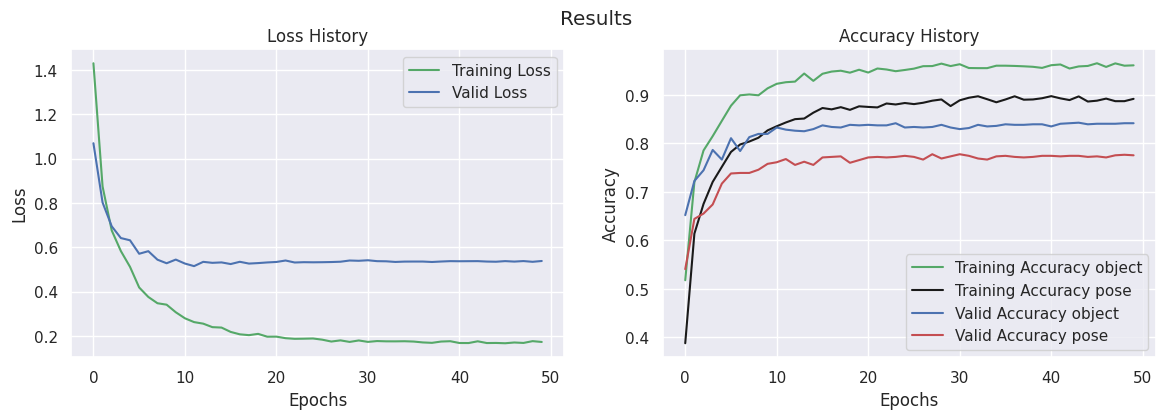

In [16]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 44
with a validation loss of: 0.5354021 and a validation accuracy of: 84.2510998249054


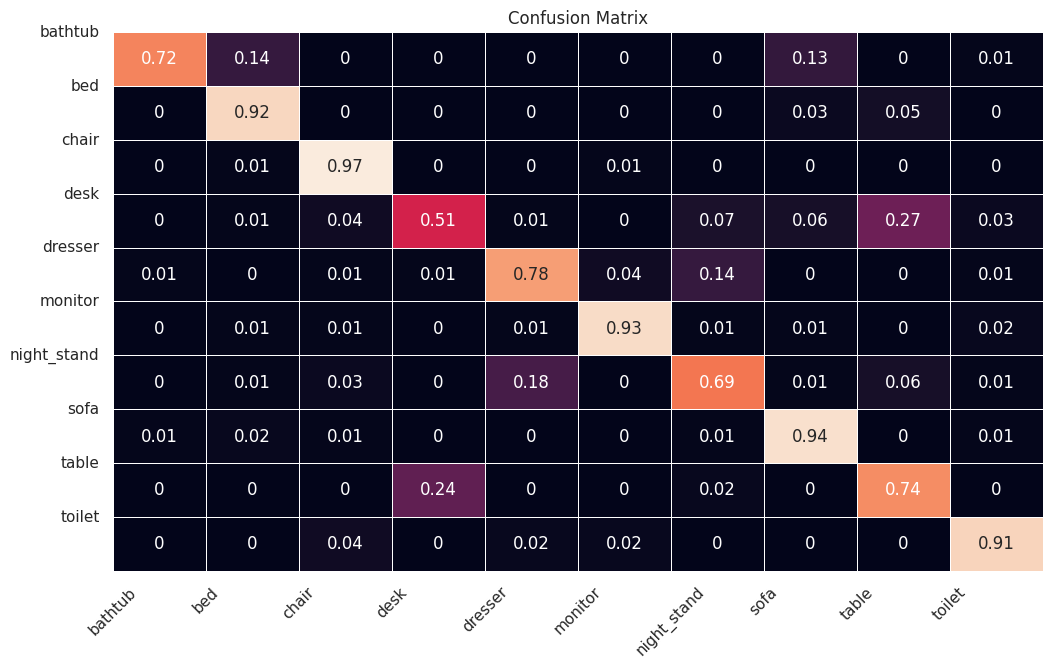

In [17]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 44
with a validation loss of: 0.5354021 and a validation accuracy of: 84.2510998249054


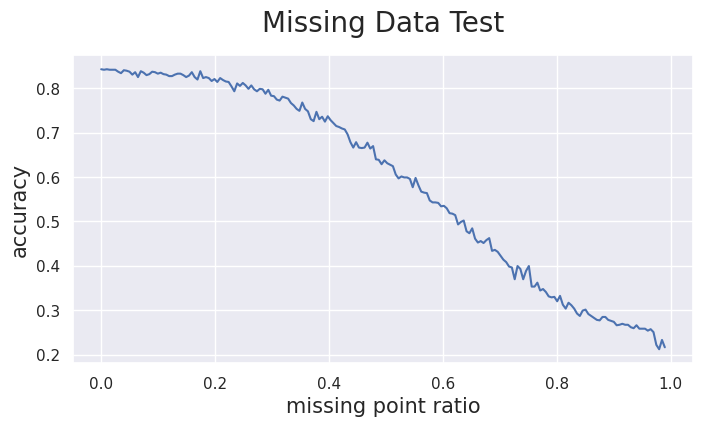

In [18]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [19]:
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [20]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.2668126821517944: : 62it [00:17,  3.48it/s]
29it [00:02, 12.58it/s]


epoch:  1 / 50
time: 20.16 seconds
train-loss: 1.57, train-acc-object: 46.19%, train-acc-pose: 35.81%
valid-loss: 1.26, valid-acc-object: 57.93%, train-acc-pose: 50.88%



Train loss: 0.9383965730667114: : 62it [00:17,  3.62it/s]
29it [00:02, 12.75it/s]


epoch:  2 / 50
time: 19.42 seconds
train-loss: 1.01, train-acc-object: 66.38%, train-acc-pose: 56.15%
valid-loss: 1.00, valid-acc-object: 63.22%, train-acc-pose: 61.23%



Train loss: 0.6897582411766052: : 62it [00:17,  3.46it/s]
29it [00:02, 12.57it/s]


epoch:  3 / 50
time: 20.22 seconds
train-loss: 0.77, train-acc-object: 73.79%, train-acc-pose: 66.43%
valid-loss: 0.75, valid-acc-object: 74.01%, train-acc-pose: 66.30%



Train loss: 0.7319108843803406: : 62it [00:17,  3.62it/s]
29it [00:02, 12.46it/s]


epoch:  4 / 50
time: 19.46 seconds
train-loss: 0.66, train-acc-object: 77.39%, train-acc-pose: 71.02%
valid-loss: 0.70, valid-acc-object: 76.32%, train-acc-pose: 66.52%



Train loss: 0.4616757333278656: : 62it [00:17,  3.46it/s]
29it [00:02, 12.38it/s]


epoch:  5 / 50
time: 20.26 seconds
train-loss: 0.56, train-acc-object: 81.70%, train-acc-pose: 74.07%
valid-loss: 0.66, valid-acc-object: 78.41%, train-acc-pose: 68.50%



Train loss: 0.5303258895874023: : 62it [00:17,  3.64it/s]
29it [00:02, 12.68it/s]


epoch:  6 / 50
time: 19.33 seconds
train-loss: 0.45, train-acc-object: 85.51%, train-acc-pose: 76.44%
valid-loss: 0.62, valid-acc-object: 77.86%, train-acc-pose: 73.46%



Train loss: 0.3149547576904297: : 62it [00:17,  3.47it/s]
29it [00:02, 12.25it/s]


epoch:  7 / 50
time: 20.27 seconds
train-loss: 0.41, train-acc-object: 87.50%, train-acc-pose: 78.58%
valid-loss: 0.58, valid-acc-object: 80.40%, train-acc-pose: 71.04%



Train loss: 0.4006936550140381: : 62it [00:17,  3.64it/s]
29it [00:02, 12.47it/s]


epoch:  8 / 50
time: 19.37 seconds
train-loss: 0.37, train-acc-object: 88.56%, train-acc-pose: 80.59%
valid-loss: 0.57, valid-acc-object: 80.73%, train-acc-pose: 73.35%



Train loss: 0.2433532476425171: : 62it [00:17,  3.47it/s]
29it [00:02, 12.26it/s]


epoch:  9 / 50
time: 20.27 seconds
train-loss: 0.34, train-acc-object: 89.47%, train-acc-pose: 80.59%
valid-loss: 0.56, valid-acc-object: 80.62%, train-acc-pose: 73.24%



Train loss: 0.525300920009613: : 62it [00:17,  3.61it/s]
29it [00:02, 12.36it/s]


epoch: 10 / 50
time: 19.53 seconds
train-loss: 0.34, train-acc-object: 90.30%, train-acc-pose: 81.45%
valid-loss: 0.55, valid-acc-object: 82.82%, train-acc-pose: 72.91%



Train loss: 0.25095975399017334: : 62it [00:17,  3.48it/s]
29it [00:02, 12.35it/s]


epoch: 11 / 50
time: 20.18 seconds
train-loss: 0.29, train-acc-object: 92.19%, train-acc-pose: 83.09%
valid-loss: 0.54, valid-acc-object: 83.70%, train-acc-pose: 73.68%



Train loss: 0.2904953956604004: : 62it [00:17,  3.63it/s]
29it [00:02, 12.67it/s]


epoch: 12 / 50
time: 19.39 seconds
train-loss: 0.28, train-acc-object: 92.06%, train-acc-pose: 84.30%
valid-loss: 0.55, valid-acc-object: 82.93%, train-acc-pose: 74.78%



Train loss: 0.32363390922546387: : 62it [00:17,  3.46it/s]
29it [00:02, 12.67it/s]


epoch: 13 / 50
time: 20.21 seconds
train-loss: 0.26, train-acc-object: 92.26%, train-acc-pose: 85.08%
valid-loss: 0.54, valid-acc-object: 83.26%, train-acc-pose: 74.89%



Train loss: 0.2848975658416748: : 62it [00:17,  3.65it/s]
29it [00:02, 12.34it/s]


epoch: 14 / 50
time: 19.37 seconds
train-loss: 0.26, train-acc-object: 92.64%, train-acc-pose: 84.58%
valid-loss: 0.54, valid-acc-object: 82.82%, train-acc-pose: 75.66%



Train loss: 0.17829027771949768: : 62it [00:17,  3.48it/s]
29it [00:02, 12.26it/s]


epoch: 15 / 50
time: 20.22 seconds
train-loss: 0.24, train-acc-object: 93.50%, train-acc-pose: 86.01%
valid-loss: 0.54, valid-acc-object: 82.27%, train-acc-pose: 75.11%



Train loss: 0.3179764747619629: : 62it [00:17,  3.64it/s]
29it [00:02, 12.33it/s]


epoch: 16 / 50
time: 19.41 seconds
train-loss: 0.24, train-acc-object: 93.17%, train-acc-pose: 85.71%
valid-loss: 0.55, valid-acc-object: 84.25%, train-acc-pose: 75.88%



Train loss: 0.26476699113845825: : 62it [00:18,  3.44it/s]
29it [00:02, 11.84it/s]


epoch: 17 / 50
time: 20.47 seconds
train-loss: 0.21, train-acc-object: 94.53%, train-acc-pose: 86.92%
valid-loss: 0.55, valid-acc-object: 84.69%, train-acc-pose: 75.22%



Train loss: 0.22991937398910522: : 62it [00:17,  3.61it/s]
29it [00:02, 12.26it/s]


epoch: 18 / 50
time: 19.54 seconds
train-loss: 0.22, train-acc-object: 94.25%, train-acc-pose: 86.47%
valid-loss: 0.55, valid-acc-object: 83.81%, train-acc-pose: 75.44%



Train loss: 0.2094772905111313: : 62it [00:17,  3.45it/s]
29it [00:02, 12.10it/s]


epoch: 19 / 50
time: 20.39 seconds
train-loss: 0.21, train-acc-object: 94.71%, train-acc-pose: 86.69%
valid-loss: 0.55, valid-acc-object: 83.92%, train-acc-pose: 76.32%



Train loss: 0.2382873296737671: : 62it [00:17,  3.60it/s]
29it [00:02, 12.41it/s]


epoch: 20 / 50
time: 19.57 seconds
train-loss: 0.21, train-acc-object: 94.13%, train-acc-pose: 86.52%
valid-loss: 0.54, valid-acc-object: 83.26%, train-acc-pose: 76.76%



Train loss: 0.1783747673034668: : 62it [00:18,  3.44it/s]
29it [00:02, 12.21it/s]


epoch: 21 / 50
time: 20.42 seconds
train-loss: 0.20, train-acc-object: 94.66%, train-acc-pose: 87.65%
valid-loss: 0.55, valid-acc-object: 84.36%, train-acc-pose: 76.32%



Train loss: 0.16253425180912018: : 62it [00:17,  3.61it/s]
29it [00:02, 12.39it/s]


epoch: 22 / 50
time: 19.54 seconds
train-loss: 0.20, train-acc-object: 94.86%, train-acc-pose: 87.15%
valid-loss: 0.56, valid-acc-object: 84.36%, train-acc-pose: 76.76%



Train loss: 0.22372230887413025: : 62it [00:17,  3.46it/s]
29it [00:02, 12.45it/s]


epoch: 23 / 50
time: 20.27 seconds
train-loss: 0.20, train-acc-object: 94.88%, train-acc-pose: 87.42%
valid-loss: 0.55, valid-acc-object: 83.92%, train-acc-pose: 75.99%



Train loss: 0.1626695990562439: : 62it [00:17,  3.62it/s]
29it [00:02, 12.51it/s]


epoch: 24 / 50
time: 19.47 seconds
train-loss: 0.19, train-acc-object: 94.88%, train-acc-pose: 87.40%
valid-loss: 0.55, valid-acc-object: 84.69%, train-acc-pose: 76.54%



Train loss: 0.21711957454681396: : 62it [00:17,  3.46it/s]
29it [00:02, 12.40it/s]


epoch: 25 / 50
time: 20.27 seconds
train-loss: 0.19, train-acc-object: 95.44%, train-acc-pose: 87.47%
valid-loss: 0.56, valid-acc-object: 84.47%, train-acc-pose: 76.65%



Train loss: 0.13256850838661194: : 62it [00:17,  3.60it/s]
29it [00:02, 12.30it/s]


epoch: 26 / 50
time: 19.59 seconds
train-loss: 0.20, train-acc-object: 94.91%, train-acc-pose: 87.73%
valid-loss: 0.56, valid-acc-object: 84.69%, train-acc-pose: 76.21%



Train loss: 0.15797197818756104: : 62it [00:18,  3.44it/s]
29it [00:02, 12.05it/s]


epoch: 27 / 50
time: 20.43 seconds
train-loss: 0.19, train-acc-object: 95.44%, train-acc-pose: 88.13%
valid-loss: 0.56, valid-acc-object: 84.47%, train-acc-pose: 76.54%



Train loss: 0.13319964706897736: : 62it [00:17,  3.59it/s]
29it [00:02, 12.46it/s]


epoch: 28 / 50
time: 19.63 seconds
train-loss: 0.18, train-acc-object: 95.54%, train-acc-pose: 87.78%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 76.10%



Train loss: 0.2001001238822937: : 62it [00:18,  3.42it/s]
29it [00:02, 12.16it/s]


epoch: 29 / 50
time: 20.51 seconds
train-loss: 0.19, train-acc-object: 95.34%, train-acc-pose: 88.03%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 76.32%



Train loss: 0.16841919720172882: : 62it [00:17,  3.58it/s]
29it [00:02, 12.19it/s]


epoch: 30 / 50
time: 19.70 seconds
train-loss: 0.18, train-acc-object: 95.44%, train-acc-pose: 88.51%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 76.43%



Train loss: 0.1654616892337799: : 62it [00:18,  3.44it/s]
29it [00:02, 12.34it/s]


epoch: 31 / 50
time: 20.40 seconds
train-loss: 0.19, train-acc-object: 94.96%, train-acc-pose: 87.95%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 77.09%



Train loss: 0.15472857654094696: : 62it [00:17,  3.59it/s]
29it [00:02, 12.12it/s]


epoch: 32 / 50
time: 19.66 seconds
train-loss: 0.18, train-acc-object: 96.07%, train-acc-pose: 88.00%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 77.09%



Train loss: 0.2371678352355957: : 62it [00:18,  3.42it/s]
29it [00:02, 11.96it/s]


epoch: 33 / 50
time: 20.54 seconds
train-loss: 0.18, train-acc-object: 95.72%, train-acc-pose: 88.00%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 76.76%



Train loss: 0.17303431034088135: : 62it [00:17,  3.57it/s]
29it [00:02, 10.89it/s]


epoch: 34 / 50
time: 20.06 seconds
train-loss: 0.18, train-acc-object: 95.21%, train-acc-pose: 88.84%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 76.65%



Train loss: 0.18487270176410675: : 62it [00:17,  3.45it/s]
29it [00:02, 11.93it/s]


epoch: 35 / 50
time: 20.40 seconds
train-loss: 0.18, train-acc-object: 95.82%, train-acc-pose: 88.84%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 76.65%



Train loss: 0.1896965056657791: : 62it [00:17,  3.61it/s]
29it [00:02,  9.89it/s]


epoch: 36 / 50
time: 20.13 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.66%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 76.98%



Train loss: 0.16701582074165344: : 62it [00:17,  3.48it/s]
29it [00:02, 12.12it/s]


epoch: 37 / 50
time: 20.21 seconds
train-loss: 0.17, train-acc-object: 95.77%, train-acc-pose: 88.53%
valid-loss: 0.56, valid-acc-object: 84.91%, train-acc-pose: 76.76%



Train loss: 0.11721718311309814: : 62it [00:17,  3.57it/s]
29it [00:03,  8.75it/s]


epoch: 38 / 50
time: 20.72 seconds
train-loss: 0.17, train-acc-object: 95.99%, train-acc-pose: 89.36%
valid-loss: 0.56, valid-acc-object: 84.80%, train-acc-pose: 76.76%



Train loss: 0.18297028541564941: : 62it [00:17,  3.54it/s]
29it [00:02, 11.97it/s]


epoch: 39 / 50
time: 19.96 seconds
train-loss: 0.18, train-acc-object: 95.74%, train-acc-pose: 88.51%
valid-loss: 0.56, valid-acc-object: 85.13%, train-acc-pose: 76.76%



Train loss: 0.09644187986850739: : 62it [00:17,  3.58it/s]
29it [00:03,  7.77it/s]


epoch: 40 / 50
time: 21.07 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.31%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 76.54%



Train loss: 0.22609306871891022: : 62it [00:17,  3.57it/s]
29it [00:02, 11.94it/s]


epoch: 41 / 50
time: 19.80 seconds
train-loss: 0.18, train-acc-object: 95.51%, train-acc-pose: 89.19%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.87%



Train loss: 0.18452537059783936: : 62it [00:17,  3.51it/s]
29it [00:03,  8.82it/s]


epoch: 42 / 50
time: 20.97 seconds
train-loss: 0.18, train-acc-object: 95.39%, train-acc-pose: 88.46%
valid-loss: 0.56, valid-acc-object: 85.02%, train-acc-pose: 76.54%



Train loss: 0.18917647004127502: : 62it [00:17,  3.55it/s]
29it [00:02, 12.05it/s]


epoch: 43 / 50
time: 19.87 seconds
train-loss: 0.18, train-acc-object: 95.82%, train-acc-pose: 89.16%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 76.65%



Train loss: 0.1793268620967865: : 62it [00:17,  3.45it/s]
29it [00:02, 10.60it/s]


epoch: 44 / 50
time: 20.70 seconds
train-loss: 0.17, train-acc-object: 95.94%, train-acc-pose: 88.99%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.43%



Train loss: 0.13469773530960083: : 62it [00:17,  3.56it/s]
29it [00:02, 11.93it/s]


epoch: 45 / 50
time: 19.87 seconds
train-loss: 0.18, train-acc-object: 95.79%, train-acc-pose: 88.76%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.54%



Train loss: 0.1275745928287506: : 62it [00:18,  3.41it/s]
29it [00:02, 11.85it/s]


epoch: 46 / 50
time: 20.64 seconds
train-loss: 0.18, train-acc-object: 95.67%, train-acc-pose: 88.96%
valid-loss: 0.56, valid-acc-object: 84.69%, train-acc-pose: 76.65%



Train loss: 0.2214113473892212: : 62it [00:17,  3.59it/s]
29it [00:02, 12.00it/s]


epoch: 47 / 50
time: 19.72 seconds
train-loss: 0.18, train-acc-object: 95.77%, train-acc-pose: 88.73%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.54%



Train loss: 0.13888120651245117: : 62it [00:18,  3.42it/s]
29it [00:02, 12.07it/s]


epoch: 48 / 50
time: 20.53 seconds
train-loss: 0.18, train-acc-object: 95.56%, train-acc-pose: 88.58%
valid-loss: 0.57, valid-acc-object: 85.13%, train-acc-pose: 76.98%



Train loss: 0.3183962404727936: : 62it [00:17,  3.58it/s]
29it [00:02, 11.76it/s]


epoch: 49 / 50
time: 19.81 seconds
train-loss: 0.18, train-acc-object: 95.44%, train-acc-pose: 89.06%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 76.65%



Train loss: 0.10173514485359192: : 62it [00:18,  3.38it/s]
29it [00:02, 11.76it/s]

epoch: 50 / 50
time: 20.84 seconds
train-loss: 0.18, train-acc-object: 95.59%, train-acc-pose: 88.91%
valid-loss: 0.57, valid-acc-object: 84.80%, train-acc-pose: 76.65%



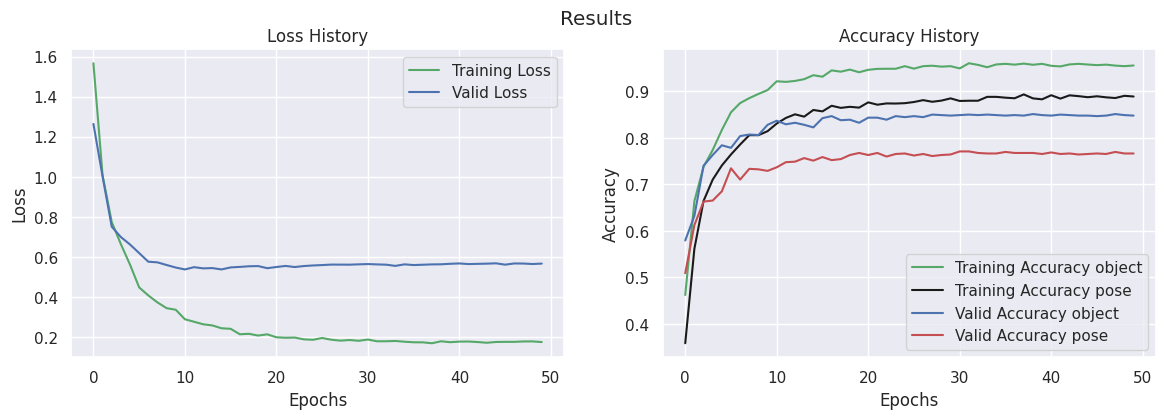

In [21]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 39
with a validation loss of: 0.56364936 and a validation accuracy of: 85.13215780258179


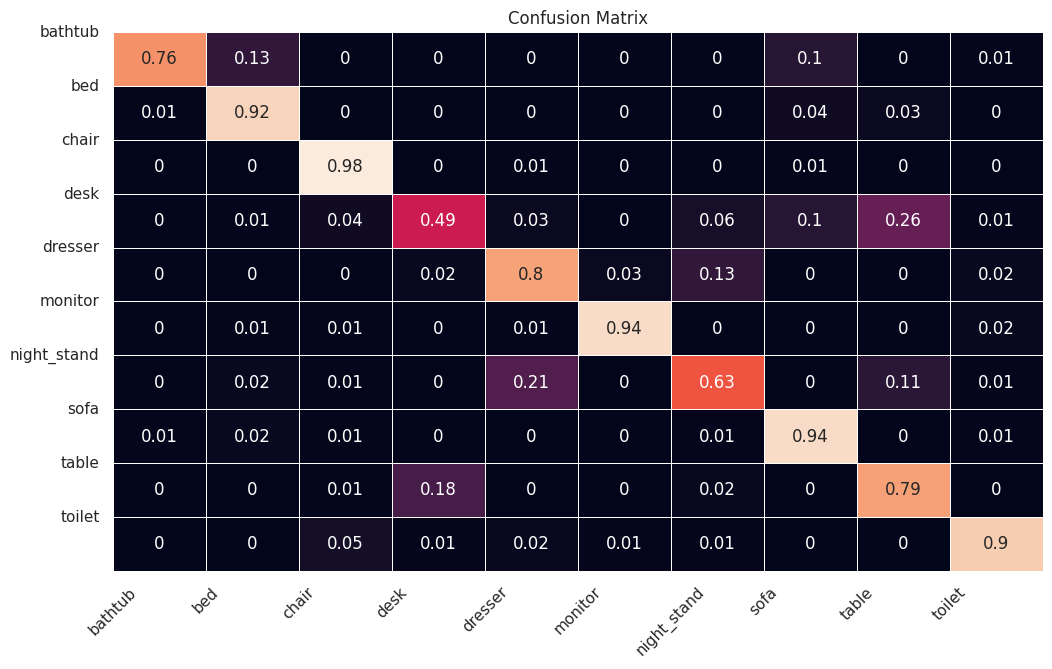

In [22]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 39
with a validation loss of: 0.56364936 and a validation accuracy of: 85.13215780258179


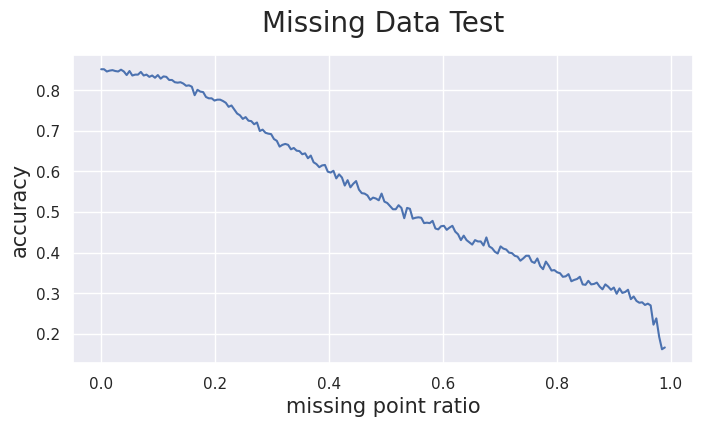

In [23]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [24]:
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [25]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
62.359375


Train loss: 1.0368119478225708: : 62it [00:27,  2.26it/s]
29it [00:03,  9.67it/s]


epoch:  1 / 50
time: 30.41 seconds
train-loss: 1.54, train-acc-object: 47.20%, train-acc-pose: 35.08%
valid-loss: 1.61, valid-acc-object: 51.10%, train-acc-pose: 51.76%



Train loss: 0.9178414940834045: : 62it [00:27,  2.29it/s]
29it [00:03,  8.46it/s]


epoch:  2 / 50
time: 30.52 seconds
train-loss: 0.97, train-acc-object: 68.62%, train-acc-pose: 57.26%
valid-loss: 1.23, valid-acc-object: 65.09%, train-acc-pose: 61.89%



Train loss: 0.6168303489685059: : 62it [00:26,  2.30it/s]
29it [00:02, 10.46it/s]


epoch:  3 / 50
time: 29.69 seconds
train-loss: 0.73, train-acc-object: 76.16%, train-acc-pose: 66.94%
valid-loss: 0.92, valid-acc-object: 73.79%, train-acc-pose: 64.76%



Train loss: 0.5852303504943848: : 62it [00:27,  2.28it/s]
29it [00:02, 10.30it/s]


epoch:  4 / 50
time: 30.07 seconds
train-loss: 0.62, train-acc-object: 80.04%, train-acc-pose: 71.27%
valid-loss: 0.93, valid-acc-object: 77.42%, train-acc-pose: 67.40%



Train loss: 0.4540993571281433: : 62it [00:27,  2.28it/s]
29it [00:03,  7.29it/s]


epoch:  5 / 50
time: 31.23 seconds
train-loss: 0.55, train-acc-object: 82.86%, train-acc-pose: 73.51%
valid-loss: 0.90, valid-acc-object: 77.09%, train-acc-pose: 70.59%



Train loss: 0.4337289333343506: : 62it [00:27,  2.28it/s]
29it [00:02, 10.33it/s]


epoch:  6 / 50
time: 30.00 seconds
train-loss: 0.43, train-acc-object: 87.35%, train-acc-pose: 76.94%
valid-loss: 0.67, valid-acc-object: 81.06%, train-acc-pose: 71.92%



Train loss: 0.4049973487854004: : 62it [00:27,  2.27it/s]
29it [00:02, 10.50it/s]


epoch:  7 / 50
time: 30.10 seconds
train-loss: 0.38, train-acc-object: 88.96%, train-acc-pose: 78.58%
valid-loss: 0.68, valid-acc-object: 83.15%, train-acc-pose: 71.59%



Train loss: 0.35196831822395325: : 62it [00:27,  2.29it/s]
29it [00:03,  9.19it/s]


epoch:  8 / 50
time: 30.28 seconds
train-loss: 0.37, train-acc-object: 88.73%, train-acc-pose: 79.06%
valid-loss: 0.61, valid-acc-object: 84.36%, train-acc-pose: 73.79%



Train loss: 0.420576274394989: : 62it [00:27,  2.27it/s]
29it [00:03,  8.90it/s]


epoch:  9 / 50
time: 30.55 seconds
train-loss: 0.32, train-acc-object: 91.03%, train-acc-pose: 79.39%
valid-loss: 0.59, valid-acc-object: 85.24%, train-acc-pose: 74.67%



Train loss: 0.31539416313171387: : 62it [00:27,  2.29it/s]
29it [00:02, 10.48it/s]


epoch: 10 / 50
time: 29.92 seconds
train-loss: 0.31, train-acc-object: 91.63%, train-acc-pose: 80.12%
valid-loss: 0.61, valid-acc-object: 83.37%, train-acc-pose: 72.47%



Train loss: 0.23032192885875702: : 62it [00:27,  2.28it/s]
29it [00:02, 10.50it/s]


epoch: 11 / 50
time: 29.97 seconds
train-loss: 0.28, train-acc-object: 92.26%, train-acc-pose: 81.85%
valid-loss: 0.52, valid-acc-object: 85.46%, train-acc-pose: 73.24%



Train loss: 0.27415430545806885: : 62it [00:27,  2.28it/s]
29it [00:04,  7.06it/s]


epoch: 12 / 50
time: 31.36 seconds
train-loss: 0.26, train-acc-object: 93.07%, train-acc-pose: 81.83%
valid-loss: 0.52, valid-acc-object: 85.35%, train-acc-pose: 75.77%



Train loss: 0.23549333214759827: : 62it [00:27,  2.28it/s]
29it [00:02, 10.47it/s]


epoch: 13 / 50
time: 30.02 seconds
train-loss: 0.25, train-acc-object: 93.15%, train-acc-pose: 82.38%
valid-loss: 0.52, valid-acc-object: 84.69%, train-acc-pose: 77.09%



Train loss: 0.21867363154888153: : 62it [00:27,  2.27it/s]
29it [00:02, 10.38it/s]


epoch: 14 / 50
time: 30.18 seconds
train-loss: 0.24, train-acc-object: 93.70%, train-acc-pose: 82.81%
valid-loss: 0.49, valid-acc-object: 86.89%, train-acc-pose: 74.45%



Train loss: 0.2694200277328491: : 62it [00:27,  2.28it/s]
29it [00:03,  8.29it/s]


epoch: 15 / 50
time: 30.75 seconds
train-loss: 0.23, train-acc-object: 94.00%, train-acc-pose: 84.07%
valid-loss: 0.50, valid-acc-object: 83.59%, train-acc-pose: 76.87%



Train loss: 0.1773369461297989: : 62it [00:27,  2.26it/s]
29it [00:02, 10.09it/s]


epoch: 16 / 50
time: 30.36 seconds
train-loss: 0.21, train-acc-object: 94.98%, train-acc-pose: 84.85%
valid-loss: 0.48, valid-acc-object: 85.02%, train-acc-pose: 77.75%



Train loss: 0.17029136419296265: : 62it [00:27,  2.28it/s]
29it [00:02, 10.39it/s]


epoch: 17 / 50
time: 30.02 seconds
train-loss: 0.20, train-acc-object: 95.44%, train-acc-pose: 85.23%
valid-loss: 0.47, valid-acc-object: 87.11%, train-acc-pose: 76.98%



Train loss: 0.1400892585515976: : 62it [00:27,  2.27it/s]
29it [00:02, 10.40it/s]


epoch: 18 / 50
time: 30.14 seconds
train-loss: 0.20, train-acc-object: 95.26%, train-acc-pose: 84.95%
valid-loss: 0.47, valid-acc-object: 86.23%, train-acc-pose: 76.65%



Train loss: 0.2405148297548294: : 62it [00:27,  2.28it/s]
29it [00:03,  7.63it/s]


epoch: 19 / 50
time: 30.98 seconds
train-loss: 0.19, train-acc-object: 95.56%, train-acc-pose: 85.91%
valid-loss: 0.46, valid-acc-object: 86.34%, train-acc-pose: 76.65%



Train loss: 0.2080429345369339: : 62it [00:26,  2.30it/s]
29it [00:02, 10.48it/s]


epoch: 20 / 50
time: 29.75 seconds
train-loss: 0.18, train-acc-object: 95.89%, train-acc-pose: 85.99%
valid-loss: 0.46, valid-acc-object: 86.56%, train-acc-pose: 76.76%



Train loss: 0.20211173593997955: : 62it [00:26,  2.30it/s]
29it [00:02, 10.35it/s]


epoch: 21 / 50
time: 29.73 seconds
train-loss: 0.18, train-acc-object: 95.84%, train-acc-pose: 86.47%
valid-loss: 0.46, valid-acc-object: 86.56%, train-acc-pose: 76.54%



Train loss: 0.20847801864147186: : 62it [00:26,  2.30it/s]
29it [00:03,  8.96it/s]


epoch: 22 / 50
time: 30.22 seconds
train-loss: 0.17, train-acc-object: 96.04%, train-acc-pose: 87.02%
valid-loss: 0.46, valid-acc-object: 86.56%, train-acc-pose: 77.64%



Train loss: 0.20772436261177063: : 62it [00:27,  2.29it/s]
29it [00:03,  8.72it/s]


epoch: 23 / 50
time: 30.37 seconds
train-loss: 0.17, train-acc-object: 96.19%, train-acc-pose: 87.27%
valid-loss: 0.45, valid-acc-object: 87.56%, train-acc-pose: 77.53%



Train loss: 0.17173507809638977: : 62it [00:26,  2.31it/s]
29it [00:02, 10.34it/s]


epoch: 24 / 50
time: 29.70 seconds
train-loss: 0.17, train-acc-object: 96.32%, train-acc-pose: 87.40%
valid-loss: 0.45, valid-acc-object: 87.22%, train-acc-pose: 77.64%



Train loss: 0.1895902156829834: : 62it [00:26,  2.30it/s]
29it [00:02, 10.49it/s]


epoch: 25 / 50
time: 29.68 seconds
train-loss: 0.16, train-acc-object: 96.42%, train-acc-pose: 87.17%
valid-loss: 0.45, valid-acc-object: 87.33%, train-acc-pose: 78.74%



Train loss: 0.17479422688484192: : 62it [00:26,  2.31it/s]
29it [00:03,  7.87it/s]


epoch: 26 / 50
time: 30.60 seconds
train-loss: 0.16, train-acc-object: 96.77%, train-acc-pose: 87.20%
valid-loss: 0.45, valid-acc-object: 87.56%, train-acc-pose: 76.65%



Train loss: 0.2556819021701813: : 62it [00:26,  2.30it/s]
29it [00:02,  9.93it/s]


epoch: 27 / 50
time: 29.90 seconds
train-loss: 0.16, train-acc-object: 96.57%, train-acc-pose: 87.12%
valid-loss: 0.44, valid-acc-object: 87.22%, train-acc-pose: 76.32%



Train loss: 0.14702436327934265: : 62it [00:26,  2.31it/s]
29it [00:02, 10.24it/s]


epoch: 28 / 50
time: 29.75 seconds
train-loss: 0.16, train-acc-object: 97.08%, train-acc-pose: 87.65%
valid-loss: 0.45, valid-acc-object: 87.33%, train-acc-pose: 76.65%



Train loss: 0.13420191407203674: : 62it [00:26,  2.31it/s]
29it [00:02, 10.46it/s]


epoch: 29 / 50
time: 29.63 seconds
train-loss: 0.15, train-acc-object: 97.10%, train-acc-pose: 87.17%
valid-loss: 0.44, valid-acc-object: 87.22%, train-acc-pose: 77.09%



Train loss: 0.19333258271217346: : 62it [00:26,  2.32it/s]
29it [00:03,  7.38it/s]


epoch: 30 / 50
time: 30.71 seconds
train-loss: 0.15, train-acc-object: 96.88%, train-acc-pose: 87.30%
valid-loss: 0.44, valid-acc-object: 87.00%, train-acc-pose: 77.20%



Train loss: 0.11564558744430542: : 62it [00:26,  2.30it/s]
29it [00:02, 10.42it/s]


epoch: 31 / 50
time: 29.80 seconds
train-loss: 0.15, train-acc-object: 96.80%, train-acc-pose: 87.98%
valid-loss: 0.44, valid-acc-object: 87.22%, train-acc-pose: 77.42%



Train loss: 0.1439158022403717: : 62it [00:26,  2.30it/s]
29it [00:02, 10.15it/s]


epoch: 32 / 50
time: 29.78 seconds
train-loss: 0.15, train-acc-object: 96.60%, train-acc-pose: 88.63%
valid-loss: 0.44, valid-acc-object: 87.11%, train-acc-pose: 77.64%



Train loss: 0.09204864501953125: : 62it [00:27,  2.29it/s]
29it [00:02,  9.90it/s]


epoch: 33 / 50
time: 29.97 seconds
train-loss: 0.15, train-acc-object: 97.33%, train-acc-pose: 87.35%
valid-loss: 0.44, valid-acc-object: 87.11%, train-acc-pose: 76.98%



Train loss: 0.17620253562927246: : 62it [00:27,  2.29it/s]
29it [00:03,  7.45it/s]


epoch: 34 / 50
time: 30.96 seconds
train-loss: 0.15, train-acc-object: 96.77%, train-acc-pose: 88.53%
valid-loss: 0.44, valid-acc-object: 87.67%, train-acc-pose: 77.42%



Train loss: 0.12600596249103546: : 62it [00:26,  2.30it/s]
29it [00:02, 10.25it/s]


epoch: 35 / 50
time: 29.81 seconds
train-loss: 0.15, train-acc-object: 97.00%, train-acc-pose: 88.46%
valid-loss: 0.44, valid-acc-object: 87.67%, train-acc-pose: 76.87%



Train loss: 0.15760213136672974: : 62it [00:26,  2.31it/s]
29it [00:02, 10.41it/s]


epoch: 36 / 50
time: 29.61 seconds
train-loss: 0.15, train-acc-object: 96.95%, train-acc-pose: 87.63%
valid-loss: 0.44, valid-acc-object: 87.44%, train-acc-pose: 77.09%



Train loss: 0.15123364329338074: : 62it [00:26,  2.32it/s]
29it [00:03,  9.33it/s]


epoch: 37 / 50
time: 29.85 seconds
train-loss: 0.15, train-acc-object: 96.95%, train-acc-pose: 88.00%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.09%



Train loss: 0.10177765041589737: : 62it [00:26,  2.30it/s]
29it [00:03,  8.40it/s]


epoch: 38 / 50
time: 30.43 seconds
train-loss: 0.15, train-acc-object: 96.93%, train-acc-pose: 88.51%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 76.87%



Train loss: 0.1824132353067398: : 62it [00:26,  2.30it/s]
29it [00:02, 10.10it/s]


epoch: 39 / 50
time: 29.79 seconds
train-loss: 0.15, train-acc-object: 97.08%, train-acc-pose: 87.83%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 76.76%



Train loss: 0.1440507024526596: : 62it [00:26,  2.31it/s]
29it [00:02, 10.24it/s]


epoch: 40 / 50
time: 29.71 seconds
train-loss: 0.15, train-acc-object: 96.98%, train-acc-pose: 88.16%
valid-loss: 0.44, valid-acc-object: 87.44%, train-acc-pose: 76.98%



Train loss: 0.083982914686203: : 62it [00:26,  2.31it/s]
29it [00:03,  7.78it/s]


epoch: 41 / 50
time: 30.62 seconds
train-loss: 0.15, train-acc-object: 96.75%, train-acc-pose: 88.43%
valid-loss: 0.44, valid-acc-object: 87.56%, train-acc-pose: 76.87%



Train loss: 0.09383771568536758: : 62it [00:26,  2.30it/s]
29it [00:02, 10.10it/s]


epoch: 42 / 50
time: 29.85 seconds
train-loss: 0.15, train-acc-object: 97.08%, train-acc-pose: 87.78%
valid-loss: 0.44, valid-acc-object: 87.67%, train-acc-pose: 76.87%



Train loss: 0.20268291234970093: : 62it [00:27,  2.28it/s]
29it [00:02, 10.10it/s]


epoch: 43 / 50
time: 30.11 seconds
train-loss: 0.15, train-acc-object: 97.10%, train-acc-pose: 88.28%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.09%



Train loss: 0.12487391382455826: : 62it [00:31,  2.00it/s]
29it [00:04,  7.20it/s]


epoch: 44 / 50
time: 35.06 seconds
train-loss: 0.15, train-acc-object: 97.18%, train-acc-pose: 88.31%
valid-loss: 0.44, valid-acc-object: 87.56%, train-acc-pose: 77.20%



Train loss: 0.1119048148393631: : 62it [00:27,  2.22it/s]
29it [00:02, 10.27it/s]


epoch: 45 / 50
time: 30.77 seconds
train-loss: 0.14, train-acc-object: 97.28%, train-acc-pose: 88.00%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.20%



Train loss: 0.12807393074035645: : 62it [00:27,  2.27it/s]
29it [00:02, 10.11it/s]


epoch: 46 / 50
time: 30.19 seconds
train-loss: 0.15, train-acc-object: 97.13%, train-acc-pose: 87.88%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.31%



Train loss: 0.164624884724617: : 62it [00:27,  2.26it/s]
29it [00:04,  7.19it/s]


epoch: 47 / 50
time: 31.45 seconds
train-loss: 0.15, train-acc-object: 97.05%, train-acc-pose: 88.23%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.31%



Train loss: 0.1685507893562317: : 62it [00:27,  2.27it/s]
29it [00:02, 10.42it/s]


epoch: 48 / 50
time: 30.10 seconds
train-loss: 0.15, train-acc-object: 96.82%, train-acc-pose: 88.18%
valid-loss: 0.44, valid-acc-object: 87.11%, train-acc-pose: 77.20%



Train loss: 0.1296224445104599: : 62it [00:27,  2.27it/s]
29it [00:02, 10.42it/s]


epoch: 49 / 50
time: 30.10 seconds
train-loss: 0.14, train-acc-object: 97.00%, train-acc-pose: 88.13%
valid-loss: 0.44, valid-acc-object: 87.33%, train-acc-pose: 77.20%



Train loss: 0.1430133581161499: : 62it [00:27,  2.27it/s]
29it [00:03,  7.75it/s]

epoch: 50 / 50
time: 31.13 seconds
train-loss: 0.15, train-acc-object: 97.38%, train-acc-pose: 87.47%
valid-loss: 0.44, valid-acc-object: 87.22%, train-acc-pose: 76.98%



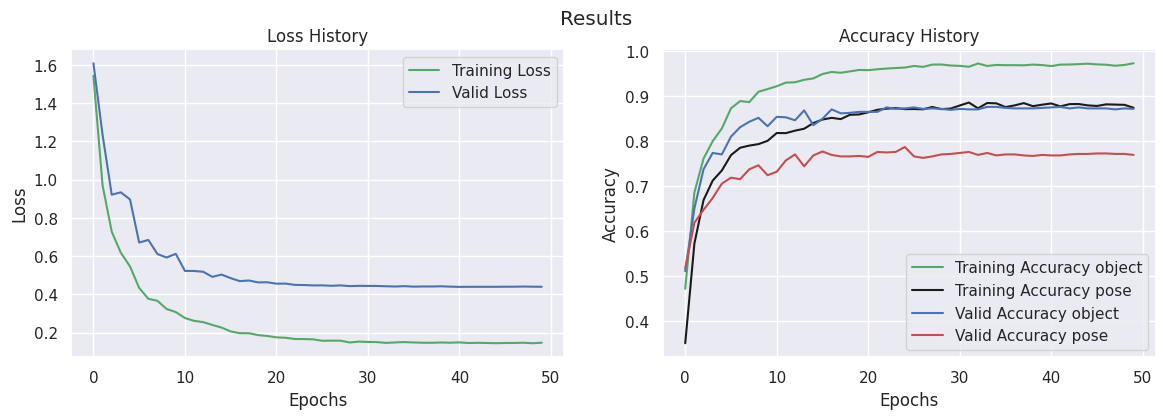

In [26]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 34
with a validation loss of: 0.44095394 and a validation accuracy of: 87.66520023345947


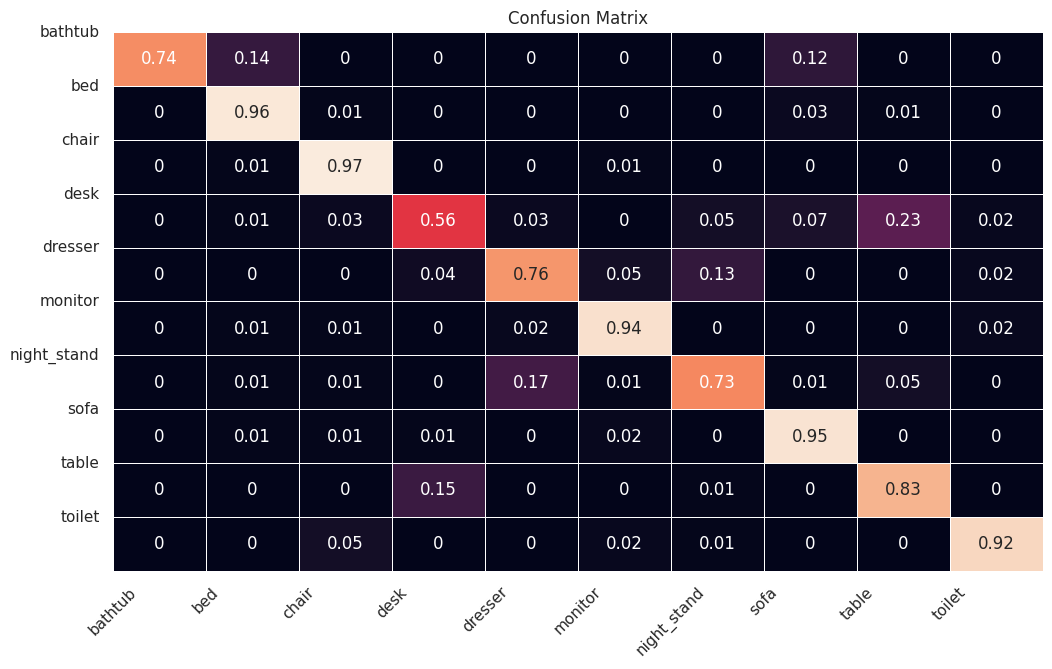

In [27]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 34
with a validation loss of: 0.44095394 and a validation accuracy of: 87.66520023345947


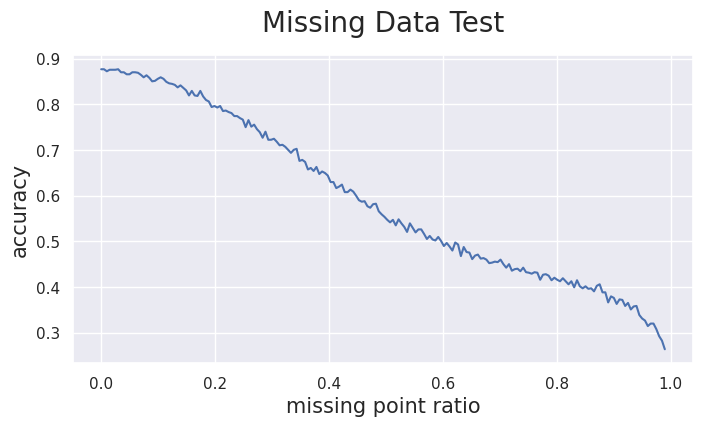

In [28]:
trainer3.missing_data_test()

# VoxNet model comparison

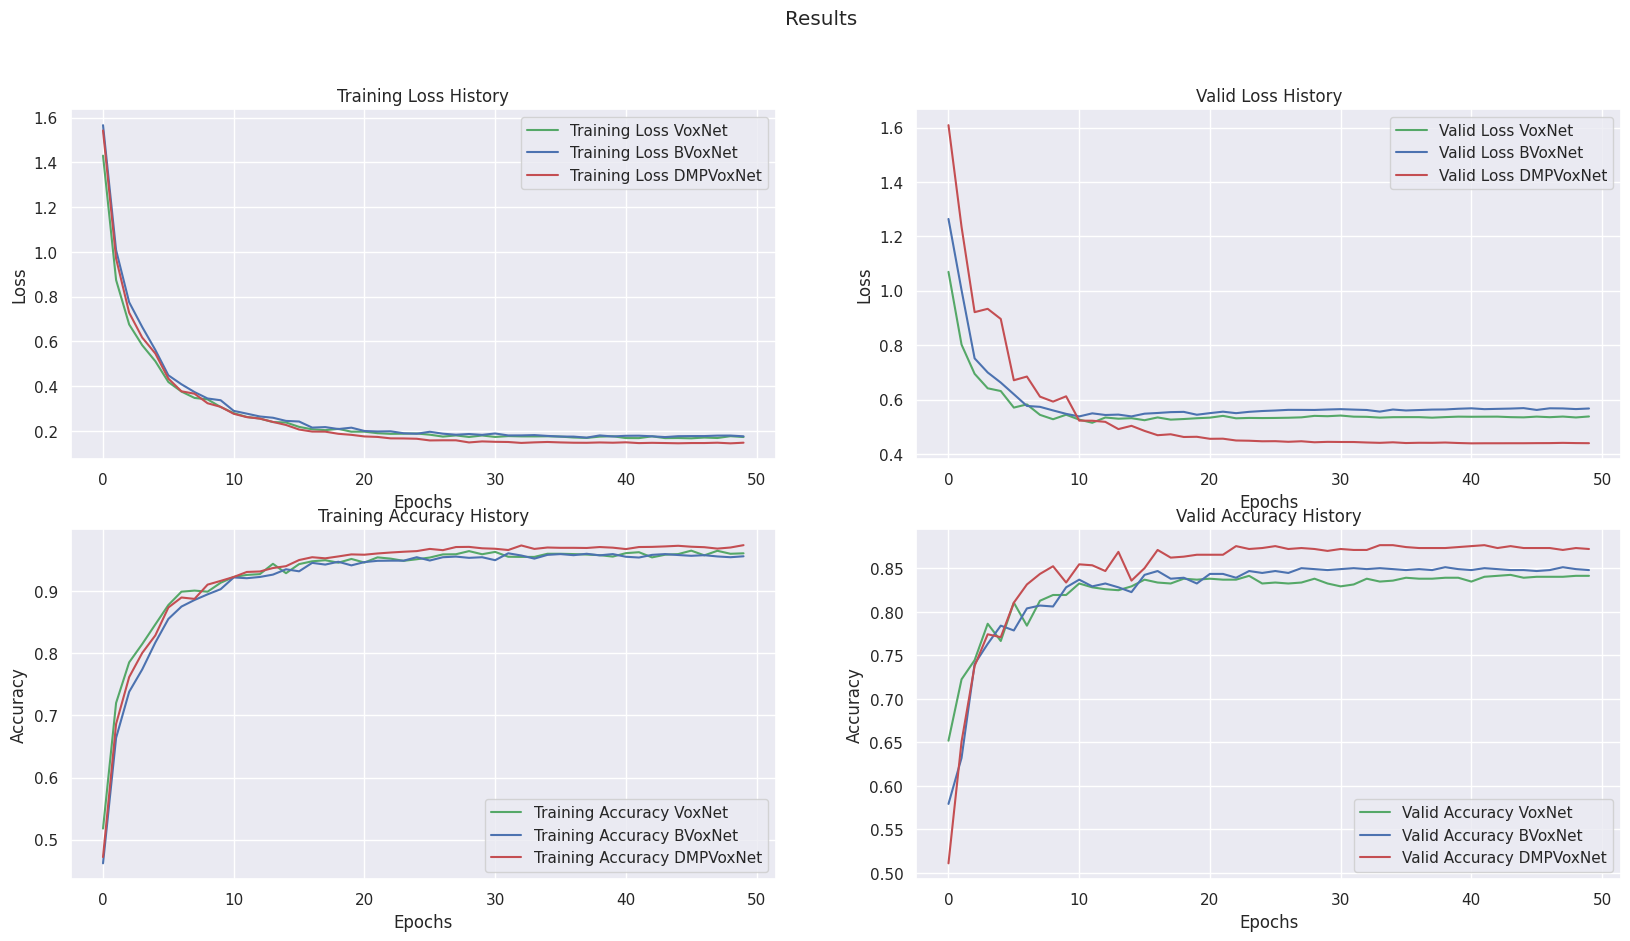

In [29]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# Data Augmentation



In [30]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        #for example in tqdm(os.listdir(examples_dir)[:100]):
        for example in tqdm(os.listdir(examples_dir)):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

rot = 0
for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        #rot = random.choice(ROTATIONS)
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if (rot%8)==0:
            mesh = mesh
            rotat = 0
            rot +=1
          elif (rot%8)==1:
            mesh.rotate(r45)
            rotat = 1
            rot +=1
          elif (rot%8)==2:
            mesh.rotate(r90)
            rotat = 2
            rot +=1
          elif (rot%8)==3:
            mesh.rotate(r135) 
            rotat = 3 
            rot +=1
          elif (rot%8)==4:
            mesh.rotate(r180)
            rotat = 4
            rot +=1
          elif (rot%8)==5:
            mesh.rotate(r225)
            rotat = 5
            rot +=1
          elif (rot%8)==6:
            mesh.rotate(r270)
            rotat = 6
            rot +=1
          else:
            mesh.rotate(r315)
            rotat = 7
            rot +=1
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:05<00:00, 19.41it/s]


In [31]:
class VoxelDataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [32]:
class VoxNet_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset_a(train=True)
      self.test_ds = VoxelDataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet_a":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      self.alpha = 2/3
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [33]:
training_hyperparameters = {
     "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}    

trainer4 = VoxNet_Trainer_a(training_hyperparameters)
trainer4.train()

model VoxNet was chosen
499.25


Train loss: 0.8201121091842651: : 499it [02:10,  3.82it/s]
29it [00:03,  8.18it/s]


epoch:  1 / 50
time: 134.24 seconds
train-loss: 1.16, train-acc-object: 61.46%, train-acc-pose: 50.88%
valid-loss: 0.84, valid-acc-object: 70.15%, train-acc-pose: 64.54%



Train loss: 0.4262244701385498: : 499it [02:10,  3.82it/s]
29it [00:03,  8.64it/s]


epoch:  2 / 50
time: 134.02 seconds
train-loss: 0.70, train-acc-object: 77.91%, train-acc-pose: 67.65%
valid-loss: 0.64, valid-acc-object: 77.64%, train-acc-pose: 71.59%



Train loss: 0.5739913582801819: : 499it [02:09,  3.86it/s]
29it [00:03,  8.84it/s]


epoch:  3 / 50
time: 132.64 seconds
train-loss: 0.57, train-acc-object: 82.83%, train-acc-pose: 71.94%
valid-loss: 0.56, valid-acc-object: 81.83%, train-acc-pose: 72.36%



Train loss: 0.5419594049453735: : 499it [02:08,  3.87it/s]
29it [00:03,  8.36it/s]


epoch:  4 / 50
time: 132.28 seconds
train-loss: 0.49, train-acc-object: 85.46%, train-acc-pose: 74.46%
valid-loss: 0.52, valid-acc-object: 83.04%, train-acc-pose: 75.66%



Train loss: 0.37573185563087463: : 499it [02:09,  3.87it/s]
29it [00:03,  8.18it/s]


epoch:  5 / 50
time: 132.64 seconds
train-loss: 0.44, train-acc-object: 87.18%, train-acc-pose: 76.46%
valid-loss: 0.51, valid-acc-object: 81.61%, train-acc-pose: 77.31%



Train loss: 0.4034278392791748: : 499it [02:08,  3.88it/s]
29it [00:03,  7.47it/s]


epoch:  6 / 50
time: 132.62 seconds
train-loss: 0.41, train-acc-object: 88.00%, train-acc-pose: 77.28%
valid-loss: 0.48, valid-acc-object: 83.81%, train-acc-pose: 77.53%



Train loss: 0.28430497646331787: : 499it [02:08,  3.88it/s]
29it [00:04,  7.15it/s]


epoch:  7 / 50
time: 132.75 seconds
train-loss: 0.38, train-acc-object: 89.03%, train-acc-pose: 78.31%
valid-loss: 0.46, valid-acc-object: 84.14%, train-acc-pose: 78.63%



Train loss: 0.334270715713501: : 499it [02:08,  3.90it/s]
29it [00:04,  6.73it/s]


epoch:  8 / 50
time: 132.44 seconds
train-loss: 0.35, train-acc-object: 90.18%, train-acc-pose: 78.89%
valid-loss: 0.44, valid-acc-object: 86.01%, train-acc-pose: 78.41%



Train loss: 0.36521509289741516: : 499it [02:07,  3.91it/s]
29it [00:04,  6.66it/s]


epoch:  9 / 50
time: 132.15 seconds
train-loss: 0.34, train-acc-object: 90.64%, train-acc-pose: 79.17%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 80.18%



Train loss: 0.29929107427597046: : 499it [02:09,  3.86it/s]
29it [00:04,  6.65it/s]


epoch: 10 / 50
time: 133.59 seconds
train-loss: 0.33, train-acc-object: 90.98%, train-acc-pose: 79.58%
valid-loss: 0.42, valid-acc-object: 87.00%, train-acc-pose: 79.96%



Train loss: 0.36253976821899414: : 499it [02:08,  3.88it/s]
29it [00:04,  6.70it/s]


epoch: 11 / 50
time: 132.83 seconds
train-loss: 0.33, train-acc-object: 91.33%, train-acc-pose: 79.89%
valid-loss: 0.42, valid-acc-object: 87.33%, train-acc-pose: 79.41%



Train loss: 0.36965951323509216: : 499it [02:08,  3.88it/s]
29it [00:04,  6.75it/s]


epoch: 12 / 50
time: 132.87 seconds
train-loss: 0.32, train-acc-object: 91.40%, train-acc-pose: 80.07%
valid-loss: 0.42, valid-acc-object: 86.34%, train-acc-pose: 80.73%



Train loss: 0.37647736072540283: : 499it [02:08,  3.88it/s]
29it [00:04,  6.61it/s]


epoch: 13 / 50
time: 133.04 seconds
train-loss: 0.31, train-acc-object: 91.68%, train-acc-pose: 80.24%
valid-loss: 0.41, valid-acc-object: 86.67%, train-acc-pose: 80.95%



Train loss: 0.278556227684021: : 499it [02:11,  3.80it/s]
29it [00:03,  7.50it/s]


epoch: 14 / 50
time: 135.34 seconds
train-loss: 0.30, train-acc-object: 92.09%, train-acc-pose: 80.67%
valid-loss: 0.41, valid-acc-object: 87.67%, train-acc-pose: 80.62%



Train loss: 0.2524486482143402: : 499it [02:10,  3.81it/s]
29it [00:03,  8.06it/s]


epoch: 15 / 50
time: 134.54 seconds
train-loss: 0.29, train-acc-object: 92.56%, train-acc-pose: 80.87%
valid-loss: 0.40, valid-acc-object: 86.78%, train-acc-pose: 80.73%



Train loss: 0.3284716010093689: : 499it [02:11,  3.79it/s]
29it [00:03,  8.55it/s]


epoch: 16 / 50
time: 135.15 seconds
train-loss: 0.29, train-acc-object: 92.52%, train-acc-pose: 81.26%
valid-loss: 0.40, valid-acc-object: 87.44%, train-acc-pose: 80.95%



Train loss: 0.25860193371772766: : 499it [02:10,  3.82it/s]
29it [00:03,  8.82it/s]


epoch: 17 / 50
time: 133.96 seconds
train-loss: 0.28, train-acc-object: 92.66%, train-acc-pose: 81.25%
valid-loss: 0.40, valid-acc-object: 87.44%, train-acc-pose: 80.84%



Train loss: 0.35986563563346863: : 499it [02:10,  3.82it/s]
29it [00:03,  8.82it/s]


epoch: 18 / 50
time: 134.08 seconds
train-loss: 0.28, train-acc-object: 92.79%, train-acc-pose: 81.44%
valid-loss: 0.40, valid-acc-object: 87.33%, train-acc-pose: 80.51%



Train loss: 0.4297630190849304: : 499it [02:11,  3.81it/s]
29it [00:03,  8.65it/s]


epoch: 19 / 50
time: 134.44 seconds
train-loss: 0.28, train-acc-object: 92.99%, train-acc-pose: 81.68%
valid-loss: 0.40, valid-acc-object: 87.00%, train-acc-pose: 80.84%



Train loss: 0.27828285098075867: : 499it [02:12,  3.76it/s]
29it [00:03,  8.84it/s]


epoch: 20 / 50
time: 135.89 seconds
train-loss: 0.28, train-acc-object: 93.09%, train-acc-pose: 81.62%
valid-loss: 0.40, valid-acc-object: 86.56%, train-acc-pose: 80.84%



Train loss: 0.23968003690242767: : 499it [02:10,  3.81it/s]
29it [00:03,  8.92it/s]


epoch: 21 / 50
time: 134.12 seconds
train-loss: 0.27, train-acc-object: 93.13%, train-acc-pose: 81.70%
valid-loss: 0.40, valid-acc-object: 87.11%, train-acc-pose: 80.07%



Train loss: 0.25452280044555664: : 499it [02:10,  3.82it/s]
29it [00:03,  8.69it/s]


epoch: 22 / 50
time: 134.06 seconds
train-loss: 0.27, train-acc-object: 93.31%, train-acc-pose: 81.87%
valid-loss: 0.40, valid-acc-object: 87.00%, train-acc-pose: 82.16%



Train loss: 0.29869553446769714: : 499it [02:10,  3.82it/s]
29it [00:03,  8.84it/s]


epoch: 23 / 50
time: 133.97 seconds
train-loss: 0.27, train-acc-object: 93.35%, train-acc-pose: 81.65%
valid-loss: 0.40, valid-acc-object: 87.78%, train-acc-pose: 80.84%



Train loss: 0.14668138325214386: : 499it [02:10,  3.82it/s]
29it [00:03,  8.75it/s]


epoch: 24 / 50
time: 133.82 seconds
train-loss: 0.27, train-acc-object: 93.39%, train-acc-pose: 81.89%
valid-loss: 0.39, valid-acc-object: 88.11%, train-acc-pose: 81.61%



Train loss: 0.22465814650058746: : 499it [02:10,  3.84it/s]
29it [00:03,  8.63it/s]


epoch: 25 / 50
time: 133.40 seconds
train-loss: 0.26, train-acc-object: 93.57%, train-acc-pose: 81.88%
valid-loss: 0.39, valid-acc-object: 88.00%, train-acc-pose: 81.72%



Train loss: 0.2842862010002136: : 499it [02:09,  3.85it/s]
29it [00:03,  8.93it/s]


epoch: 26 / 50
time: 132.99 seconds
train-loss: 0.26, train-acc-object: 93.48%, train-acc-pose: 82.00%
valid-loss: 0.39, valid-acc-object: 88.22%, train-acc-pose: 81.39%



Train loss: 0.19163760542869568: : 499it [02:08,  3.88it/s]
29it [00:03,  8.94it/s]


epoch: 27 / 50
time: 131.74 seconds
train-loss: 0.26, train-acc-object: 93.62%, train-acc-pose: 82.05%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 80.73%



Train loss: 0.27185332775115967: : 499it [02:09,  3.85it/s]
29it [00:03,  8.62it/s]


epoch: 28 / 50
time: 132.86 seconds
train-loss: 0.26, train-acc-object: 93.59%, train-acc-pose: 81.99%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 82.05%



Train loss: 0.2618662118911743: : 499it [02:10,  3.83it/s]
29it [00:03,  8.91it/s]


epoch: 29 / 50
time: 133.46 seconds
train-loss: 0.26, train-acc-object: 93.98%, train-acc-pose: 82.14%
valid-loss: 0.39, valid-acc-object: 87.33%, train-acc-pose: 81.61%



Train loss: 0.2838408350944519: : 499it [02:08,  3.88it/s]
29it [00:03,  8.58it/s]


epoch: 30 / 50
time: 132.03 seconds
train-loss: 0.26, train-acc-object: 93.67%, train-acc-pose: 82.26%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 81.61%



Train loss: 0.1419367492198944: : 499it [02:07,  3.91it/s]
29it [00:04,  6.82it/s]


epoch: 31 / 50
time: 132.06 seconds
train-loss: 0.26, train-acc-object: 93.81%, train-acc-pose: 82.48%
valid-loss: 0.39, valid-acc-object: 88.00%, train-acc-pose: 82.05%



Train loss: 0.31771689653396606: : 499it [02:07,  3.90it/s]
29it [00:04,  7.05it/s]


epoch: 32 / 50
time: 131.94 seconds
train-loss: 0.26, train-acc-object: 93.81%, train-acc-pose: 82.26%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 81.61%



Train loss: 0.2331531047821045: : 499it [02:07,  3.92it/s]
29it [00:03,  8.91it/s]


epoch: 33 / 50
time: 130.67 seconds
train-loss: 0.26, train-acc-object: 93.80%, train-acc-pose: 82.27%
valid-loss: 0.39, valid-acc-object: 88.55%, train-acc-pose: 81.94%



Train loss: 0.3160190284252167: : 499it [02:08,  3.90it/s]
29it [00:03,  9.03it/s]


epoch: 34 / 50
time: 131.31 seconds
train-loss: 0.25, train-acc-object: 93.84%, train-acc-pose: 82.31%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 82.27%



Train loss: 0.20997628569602966: : 499it [02:07,  3.91it/s]
29it [00:03,  9.15it/s]


epoch: 35 / 50
time: 130.83 seconds
train-loss: 0.25, train-acc-object: 93.88%, train-acc-pose: 82.32%
valid-loss: 0.39, valid-acc-object: 88.00%, train-acc-pose: 81.72%



Train loss: 0.18723814189434052: : 499it [02:06,  3.96it/s]
29it [00:04,  6.83it/s]


epoch: 36 / 50
time: 130.31 seconds
train-loss: 0.25, train-acc-object: 93.83%, train-acc-pose: 82.41%
valid-loss: 0.39, valid-acc-object: 88.11%, train-acc-pose: 81.83%



Train loss: 0.23059329390525818: : 499it [02:04,  4.01it/s]
29it [00:03,  9.18it/s]


epoch: 37 / 50
time: 127.60 seconds
train-loss: 0.25, train-acc-object: 94.09%, train-acc-pose: 82.58%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 82.27%



Train loss: 0.23369595408439636: : 499it [02:04,  4.00it/s]
29it [00:03,  8.38it/s]


epoch: 38 / 50
time: 128.36 seconds
train-loss: 0.25, train-acc-object: 94.13%, train-acc-pose: 82.33%
valid-loss: 0.39, valid-acc-object: 88.00%, train-acc-pose: 81.83%



Train loss: 0.28642475605010986: : 499it [02:04,  4.00it/s]
29it [00:03,  8.96it/s]


epoch: 39 / 50
time: 128.11 seconds
train-loss: 0.25, train-acc-object: 94.03%, train-acc-pose: 82.67%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 81.83%



Train loss: 0.23864006996154785: : 499it [02:05,  3.98it/s]
29it [00:03,  9.23it/s]


epoch: 40 / 50
time: 128.66 seconds
train-loss: 0.25, train-acc-object: 94.01%, train-acc-pose: 82.26%
valid-loss: 0.39, valid-acc-object: 88.00%, train-acc-pose: 81.72%



Train loss: 0.27224400639533997: : 499it [02:05,  3.96it/s]
29it [00:03,  7.67it/s]


epoch: 41 / 50
time: 129.67 seconds
train-loss: 0.25, train-acc-object: 94.01%, train-acc-pose: 82.71%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 81.61%



Train loss: 0.22164995968341827: : 499it [02:01,  4.09it/s]
29it [00:03,  9.57it/s]


epoch: 42 / 50
time: 124.96 seconds
train-loss: 0.25, train-acc-object: 93.98%, train-acc-pose: 82.24%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 81.72%



Train loss: 0.31841886043548584: : 499it [02:01,  4.12it/s]
29it [00:03,  9.00it/s]


epoch: 43 / 50
time: 124.30 seconds
train-loss: 0.25, train-acc-object: 94.05%, train-acc-pose: 82.63%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 81.83%



Train loss: 0.19919241964817047: : 499it [02:00,  4.13it/s]
29it [00:03,  8.01it/s]


epoch: 44 / 50
time: 124.56 seconds
train-loss: 0.25, train-acc-object: 94.24%, train-acc-pose: 82.54%
valid-loss: 0.39, valid-acc-object: 87.67%, train-acc-pose: 82.05%



Train loss: 0.24442675709724426: : 499it [01:59,  4.18it/s]
29it [00:02,  9.67it/s]


epoch: 45 / 50
time: 122.52 seconds
train-loss: 0.25, train-acc-object: 93.99%, train-acc-pose: 82.56%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 81.94%



Train loss: 0.2546284794807434: : 499it [01:58,  4.21it/s]
29it [00:02, 10.05it/s]


epoch: 46 / 50
time: 121.35 seconds
train-loss: 0.25, train-acc-object: 94.05%, train-acc-pose: 82.35%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 81.94%



Train loss: 0.24687880277633667: : 499it [01:58,  4.22it/s]
29it [00:02,  9.85it/s]


epoch: 47 / 50
time: 121.19 seconds
train-loss: 0.25, train-acc-object: 94.14%, train-acc-pose: 82.56%
valid-loss: 0.39, valid-acc-object: 87.78%, train-acc-pose: 81.94%



Train loss: 0.307659387588501: : 499it [02:00,  4.14it/s]
29it [00:02,  9.85it/s]


epoch: 48 / 50
time: 123.60 seconds
train-loss: 0.25, train-acc-object: 94.13%, train-acc-pose: 82.52%
valid-loss: 0.39, valid-acc-object: 87.44%, train-acc-pose: 82.05%



Train loss: 0.35517418384552: : 499it [01:57,  4.23it/s]
29it [00:03,  9.20it/s]


epoch: 49 / 50
time: 121.11 seconds
train-loss: 0.25, train-acc-object: 94.11%, train-acc-pose: 82.35%
valid-loss: 0.39, valid-acc-object: 88.22%, train-acc-pose: 82.16%



Train loss: 0.21138694882392883: : 499it [01:56,  4.28it/s]
29it [00:02,  9.97it/s]

epoch: 50 / 50
time: 119.57 seconds
train-loss: 0.25, train-acc-object: 94.05%, train-acc-pose: 82.12%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 82.38%



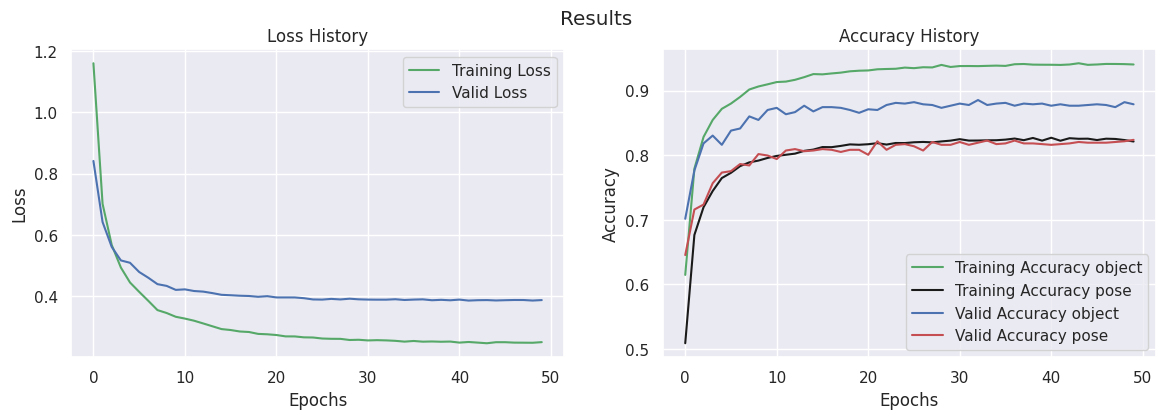

In [34]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

best model was trained at epoch: 33
with a validation loss of: 0.38831875 and a validation accuracy of: 88.54625821113586


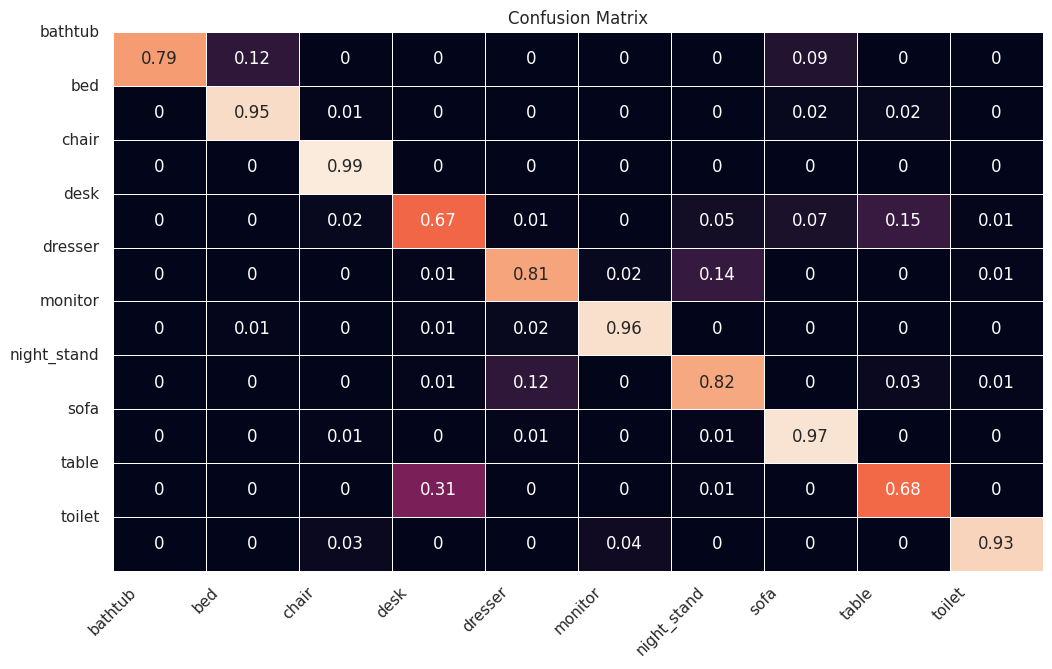

In [35]:
trainer4.generateConfusionMatrix()

best model was trained at epoch: 33
with a validation loss of: 0.38831875 and a validation accuracy of: 88.54625821113586


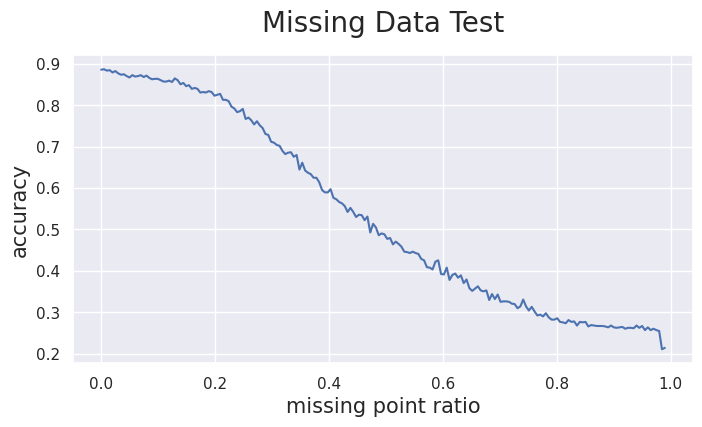

In [36]:
trainer4.missing_data_test()

In [37]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet_a'
}    

trainer5 = VoxNet_Trainer_a(training_hyperparameters)
trainer5.train()

model BatchNormVoxNet was chosen
499.25


Train loss: 0.9061537384986877: : 499it [03:00,  2.77it/s]
29it [00:03,  7.73it/s]


epoch:  1 / 50
time: 183.84 seconds
train-loss: 1.19, train-acc-object: 60.71%, train-acc-pose: 49.22%
valid-loss: 0.85, valid-acc-object: 71.59%, train-acc-pose: 62.89%



Train loss: 0.6174803972244263: : 499it [03:01,  2.75it/s]
29it [00:03,  7.56it/s]


epoch:  2 / 50
time: 185.01 seconds
train-loss: 0.69, train-acc-object: 78.44%, train-acc-pose: 66.86%
valid-loss: 0.62, valid-acc-object: 79.07%, train-acc-pose: 69.05%



Train loss: 0.4798152446746826: : 499it [03:01,  2.76it/s]
29it [00:03,  7.75it/s]


epoch:  3 / 50
time: 184.80 seconds
train-loss: 0.53, train-acc-object: 84.15%, train-acc-pose: 72.29%
valid-loss: 0.54, valid-acc-object: 82.82%, train-acc-pose: 73.35%



Train loss: 0.49501290917396545: : 499it [03:05,  2.68it/s]
29it [00:03,  7.72it/s]


epoch:  4 / 50
time: 189.66 seconds
train-loss: 0.45, train-acc-object: 87.00%, train-acc-pose: 74.85%
valid-loss: 0.50, valid-acc-object: 84.58%, train-acc-pose: 74.34%



Train loss: 0.4968063235282898: : 499it [03:02,  2.74it/s]
29it [00:03,  7.52it/s]


epoch:  5 / 50
time: 186.27 seconds
train-loss: 0.41, train-acc-object: 88.47%, train-acc-pose: 76.52%
valid-loss: 0.46, valid-acc-object: 85.35%, train-acc-pose: 75.55%



Train loss: 0.3559451699256897: : 499it [03:07,  2.66it/s]
29it [00:04,  6.40it/s]


epoch:  6 / 50
time: 192.34 seconds
train-loss: 0.38, train-acc-object: 89.48%, train-acc-pose: 77.90%
valid-loss: 0.44, valid-acc-object: 86.89%, train-acc-pose: 77.20%



Train loss: 0.26502251625061035: : 499it [03:06,  2.67it/s]
29it [00:03,  7.69it/s]


epoch:  7 / 50
time: 190.63 seconds
train-loss: 0.35, train-acc-object: 90.40%, train-acc-pose: 78.76%
valid-loss: 0.43, valid-acc-object: 86.89%, train-acc-pose: 78.96%



Train loss: 0.30182012915611267: : 499it [03:03,  2.72it/s]
29it [00:03,  7.68it/s]


epoch:  8 / 50
time: 187.37 seconds
train-loss: 0.32, train-acc-object: 91.40%, train-acc-pose: 80.09%
valid-loss: 0.41, valid-acc-object: 87.44%, train-acc-pose: 79.63%



Train loss: 0.20462214946746826: : 499it [03:03,  2.71it/s]
29it [00:03,  7.63it/s]


epoch:  9 / 50
time: 187.79 seconds
train-loss: 0.30, train-acc-object: 92.21%, train-acc-pose: 80.27%
valid-loss: 0.41, valid-acc-object: 86.78%, train-acc-pose: 78.19%



Train loss: 0.32056325674057007: : 499it [03:03,  2.72it/s]
29it [00:04,  6.85it/s]


epoch: 10 / 50
time: 187.88 seconds
train-loss: 0.29, train-acc-object: 92.33%, train-acc-pose: 80.58%
valid-loss: 0.40, valid-acc-object: 88.44%, train-acc-pose: 78.74%



Train loss: 0.35081514716148376: : 499it [03:03,  2.72it/s]
29it [00:04,  6.16it/s]


epoch: 11 / 50
time: 188.00 seconds
train-loss: 0.28, train-acc-object: 92.63%, train-acc-pose: 81.04%
valid-loss: 0.39, valid-acc-object: 87.89%, train-acc-pose: 79.19%



Train loss: 0.24821671843528748: : 499it [03:01,  2.75it/s]
29it [00:04,  5.98it/s]


epoch: 12 / 50
time: 186.15 seconds
train-loss: 0.28, train-acc-object: 92.83%, train-acc-pose: 81.31%
valid-loss: 0.38, valid-acc-object: 88.66%, train-acc-pose: 81.17%



Train loss: 0.2691219449043274: : 499it [03:00,  2.76it/s]
29it [00:04,  6.14it/s]


epoch: 13 / 50
time: 185.71 seconds
train-loss: 0.27, train-acc-object: 93.18%, train-acc-pose: 81.68%
valid-loss: 0.40, valid-acc-object: 87.67%, train-acc-pose: 78.74%



Train loss: 0.14848318696022034: : 499it [03:02,  2.73it/s]
29it [00:04,  6.37it/s]


epoch: 14 / 50
time: 187.50 seconds
train-loss: 0.26, train-acc-object: 93.54%, train-acc-pose: 82.06%
valid-loss: 0.38, valid-acc-object: 87.89%, train-acc-pose: 79.52%



Train loss: 0.23833057284355164: : 499it [03:01,  2.75it/s]
29it [00:04,  6.62it/s]


epoch: 15 / 50
time: 186.07 seconds
train-loss: 0.25, train-acc-object: 93.76%, train-acc-pose: 82.07%
valid-loss: 0.38, valid-acc-object: 88.66%, train-acc-pose: 79.85%



Train loss: 0.3188855051994324: : 499it [03:04,  2.70it/s]
29it [00:03,  7.64it/s]


epoch: 16 / 50
time: 188.39 seconds
train-loss: 0.25, train-acc-object: 93.94%, train-acc-pose: 82.40%
valid-loss: 0.38, valid-acc-object: 88.11%, train-acc-pose: 79.63%



Train loss: 0.24922195076942444: : 499it [03:04,  2.71it/s]
29it [00:03,  7.57it/s]


epoch: 17 / 50
time: 188.15 seconds
train-loss: 0.25, train-acc-object: 93.97%, train-acc-pose: 82.38%
valid-loss: 0.38, valid-acc-object: 88.33%, train-acc-pose: 79.74%



Train loss: 0.25016072392463684: : 499it [03:03,  2.73it/s]
29it [00:03,  7.97it/s]


epoch: 18 / 50
time: 186.67 seconds
train-loss: 0.24, train-acc-object: 94.14%, train-acc-pose: 82.51%
valid-loss: 0.38, valid-acc-object: 88.55%, train-acc-pose: 80.29%



Train loss: 0.17578396201133728: : 499it [03:02,  2.74it/s]
29it [00:03,  7.75it/s]


epoch: 19 / 50
time: 185.88 seconds
train-loss: 0.24, train-acc-object: 94.31%, train-acc-pose: 82.62%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 79.63%



Train loss: 0.2880710959434509: : 499it [03:02,  2.74it/s]
29it [00:03,  8.01it/s]


epoch: 20 / 50
time: 185.85 seconds
train-loss: 0.23, train-acc-object: 94.42%, train-acc-pose: 82.79%
valid-loss: 0.37, valid-acc-object: 88.44%, train-acc-pose: 80.40%



Train loss: 0.14637824892997742: : 499it [03:01,  2.75it/s]
29it [00:03,  7.74it/s]


epoch: 21 / 50
time: 185.03 seconds
train-loss: 0.24, train-acc-object: 94.36%, train-acc-pose: 82.69%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 79.63%



Train loss: 0.2543831467628479: : 499it [03:04,  2.71it/s]
29it [00:03,  7.58it/s]


epoch: 22 / 50
time: 187.85 seconds
train-loss: 0.23, train-acc-object: 94.72%, train-acc-pose: 82.93%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 80.51%



Train loss: 0.2818813621997833: : 499it [02:59,  2.78it/s]
29it [00:03,  8.35it/s]


epoch: 23 / 50
time: 182.78 seconds
train-loss: 0.23, train-acc-object: 94.77%, train-acc-pose: 82.88%
valid-loss: 0.37, valid-acc-object: 88.33%, train-acc-pose: 80.73%



Train loss: 0.20889237523078918: : 499it [02:56,  2.82it/s]
29it [00:04,  6.35it/s]


epoch: 24 / 50
time: 181.55 seconds
train-loss: 0.23, train-acc-object: 94.82%, train-acc-pose: 83.13%
valid-loss: 0.36, valid-acc-object: 88.77%, train-acc-pose: 80.51%



Train loss: 0.21966174244880676: : 499it [02:59,  2.77it/s]
29it [00:04,  6.31it/s]


epoch: 25 / 50
time: 184.48 seconds
train-loss: 0.22, train-acc-object: 94.98%, train-acc-pose: 83.06%
valid-loss: 0.37, valid-acc-object: 88.44%, train-acc-pose: 80.29%



Train loss: 0.2447229027748108: : 499it [02:58,  2.79it/s]
29it [00:03,  7.89it/s]


epoch: 26 / 50
time: 182.33 seconds
train-loss: 0.22, train-acc-object: 94.97%, train-acc-pose: 83.19%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 81.50%



Train loss: 0.25514456629753113: : 499it [02:59,  2.78it/s]
29it [00:03,  7.93it/s]


epoch: 27 / 50
time: 182.99 seconds
train-loss: 0.22, train-acc-object: 95.15%, train-acc-pose: 83.14%
valid-loss: 0.36, valid-acc-object: 88.66%, train-acc-pose: 80.84%



Train loss: 0.13465729355812073: : 499it [02:55,  2.84it/s]
29it [00:04,  6.38it/s]


epoch: 28 / 50
time: 180.34 seconds
train-loss: 0.22, train-acc-object: 95.01%, train-acc-pose: 83.10%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 80.84%



Train loss: 0.2337043285369873: : 499it [02:55,  2.85it/s]
29it [00:03,  8.29it/s]


epoch: 29 / 50
time: 178.57 seconds
train-loss: 0.22, train-acc-object: 95.08%, train-acc-pose: 83.28%
valid-loss: 0.36, valid-acc-object: 88.44%, train-acc-pose: 81.17%



Train loss: 0.2006043642759323: : 499it [02:54,  2.87it/s]
29it [00:04,  6.96it/s]


epoch: 30 / 50
time: 178.32 seconds
train-loss: 0.22, train-acc-object: 95.16%, train-acc-pose: 83.24%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 80.73%



Train loss: 0.15836596488952637: : 499it [02:53,  2.88it/s]
29it [00:03,  8.45it/s]


epoch: 31 / 50
time: 176.85 seconds
train-loss: 0.22, train-acc-object: 95.13%, train-acc-pose: 83.32%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 80.95%



Train loss: 0.3028613030910492: : 499it [02:51,  2.90it/s]
29it [00:03,  8.42it/s]


epoch: 32 / 50
time: 175.45 seconds
train-loss: 0.21, train-acc-object: 95.17%, train-acc-pose: 83.53%
valid-loss: 0.36, valid-acc-object: 89.32%, train-acc-pose: 80.73%



Train loss: 0.22855712473392487: : 499it [02:51,  2.91it/s]
29it [00:03,  8.68it/s]


epoch: 33 / 50
time: 174.83 seconds
train-loss: 0.22, train-acc-object: 95.27%, train-acc-pose: 83.51%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 80.95%



Train loss: 0.21253368258476257: : 499it [02:49,  2.94it/s]
29it [00:03,  8.76it/s]


epoch: 34 / 50
time: 173.14 seconds
train-loss: 0.22, train-acc-object: 95.07%, train-acc-pose: 83.29%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 80.40%



Train loss: 0.21445894241333008: : 499it [02:49,  2.95it/s]
29it [00:03,  8.82it/s]


epoch: 35 / 50
time: 172.55 seconds
train-loss: 0.22, train-acc-object: 95.23%, train-acc-pose: 83.34%
valid-loss: 0.36, valid-acc-object: 88.77%, train-acc-pose: 80.95%



Train loss: 0.26743078231811523: : 499it [02:48,  2.97it/s]
29it [00:03,  8.92it/s]


epoch: 36 / 50
time: 171.47 seconds
train-loss: 0.22, train-acc-object: 95.24%, train-acc-pose: 83.31%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 80.18%



Train loss: 0.18975800275802612: : 499it [02:47,  2.98it/s]
29it [00:03,  8.93it/s]


epoch: 37 / 50
time: 170.89 seconds
train-loss: 0.22, train-acc-object: 95.39%, train-acc-pose: 83.34%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 80.18%



Train loss: 0.28029948472976685: : 499it [02:47,  2.99it/s]
29it [00:03,  9.11it/s]


epoch: 38 / 50
time: 170.21 seconds
train-loss: 0.21, train-acc-object: 95.30%, train-acc-pose: 83.62%
valid-loss: 0.36, valid-acc-object: 88.99%, train-acc-pose: 80.40%



Train loss: 0.1797245740890503: : 499it [02:45,  3.01it/s]
29it [00:03,  9.14it/s]


epoch: 39 / 50
time: 168.79 seconds
train-loss: 0.21, train-acc-object: 95.37%, train-acc-pose: 83.48%
valid-loss: 0.36, valid-acc-object: 88.77%, train-acc-pose: 80.95%



Train loss: 0.2550429105758667: : 499it [02:44,  3.03it/s]
29it [00:04,  6.96it/s]


epoch: 40 / 50
time: 168.66 seconds
train-loss: 0.21, train-acc-object: 95.15%, train-acc-pose: 83.48%
valid-loss: 0.36, valid-acc-object: 88.77%, train-acc-pose: 80.62%



Train loss: 0.2014857679605484: : 499it [02:43,  3.06it/s]
29it [00:03,  9.34it/s]


epoch: 41 / 50
time: 166.43 seconds
train-loss: 0.21, train-acc-object: 95.43%, train-acc-pose: 83.40%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 80.51%



Train loss: 0.2901521921157837: : 499it [02:43,  3.05it/s]
29it [00:03,  7.63it/s]


epoch: 42 / 50
time: 167.19 seconds
train-loss: 0.21, train-acc-object: 95.37%, train-acc-pose: 83.51%
valid-loss: 0.36, valid-acc-object: 89.32%, train-acc-pose: 80.84%



Train loss: 0.24017411470413208: : 499it [02:43,  3.05it/s]
29it [00:03,  8.56it/s]


epoch: 43 / 50
time: 167.15 seconds
train-loss: 0.21, train-acc-object: 95.45%, train-acc-pose: 83.58%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 80.40%



Train loss: 0.1975160539150238: : 499it [02:43,  3.05it/s]
29it [00:03,  9.16it/s]


epoch: 44 / 50
time: 166.56 seconds
train-loss: 0.21, train-acc-object: 95.33%, train-acc-pose: 83.85%
valid-loss: 0.36, valid-acc-object: 88.88%, train-acc-pose: 80.51%



Train loss: 0.2202092707157135: : 499it [02:42,  3.07it/s]
29it [00:04,  7.17it/s]


epoch: 45 / 50
time: 166.75 seconds
train-loss: 0.21, train-acc-object: 95.32%, train-acc-pose: 83.49%
valid-loss: 0.36, valid-acc-object: 88.99%, train-acc-pose: 80.73%



Train loss: 0.19737043976783752: : 499it [02:43,  3.06it/s]
29it [00:03,  9.26it/s]


epoch: 46 / 50
time: 166.30 seconds
train-loss: 0.21, train-acc-object: 95.41%, train-acc-pose: 83.60%
valid-loss: 0.36, valid-acc-object: 89.32%, train-acc-pose: 81.17%



Train loss: 0.30582761764526367: : 499it [02:42,  3.07it/s]
29it [00:04,  6.61it/s]


epoch: 47 / 50
time: 166.91 seconds
train-loss: 0.21, train-acc-object: 95.31%, train-acc-pose: 83.53%
valid-loss: 0.36, valid-acc-object: 88.99%, train-acc-pose: 80.73%



Train loss: 0.17203304171562195: : 499it [02:41,  3.08it/s]
29it [00:03,  9.30it/s]


epoch: 48 / 50
time: 164.91 seconds
train-loss: 0.21, train-acc-object: 95.39%, train-acc-pose: 83.73%
valid-loss: 0.36, valid-acc-object: 88.99%, train-acc-pose: 80.73%



Train loss: 0.2576504051685333: : 499it [02:40,  3.10it/s]
29it [00:03,  8.07it/s]


epoch: 49 / 50
time: 164.61 seconds
train-loss: 0.21, train-acc-object: 95.42%, train-acc-pose: 83.84%
valid-loss: 0.36, valid-acc-object: 88.99%, train-acc-pose: 80.73%



Train loss: 0.21781373023986816: : 499it [02:40,  3.11it/s]
29it [00:03,  9.66it/s]

epoch: 50 / 50
time: 163.69 seconds
train-loss: 0.21, train-acc-object: 95.32%, train-acc-pose: 83.61%
valid-loss: 0.36, valid-acc-object: 89.10%, train-acc-pose: 80.51%



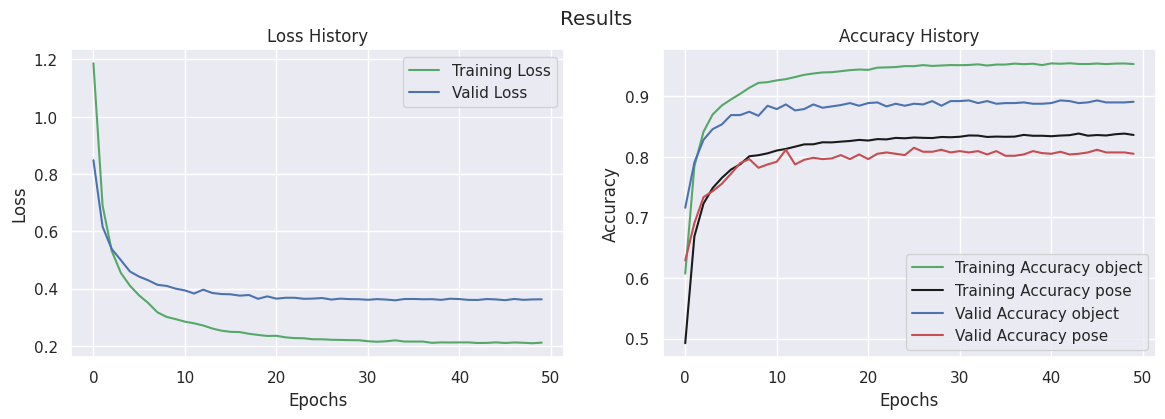

In [38]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 32
with a validation loss of: 0.36345765 and a validation accuracy of: 89.31717872619629


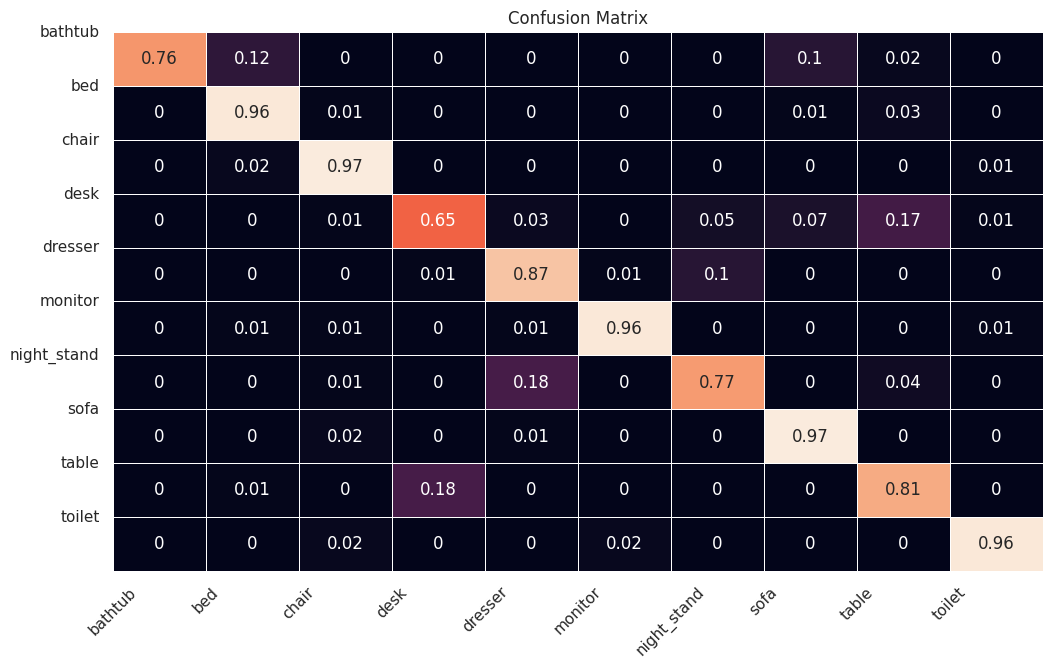

In [39]:
trainer5.generateConfusionMatrix()

best model was trained at epoch: 32
with a validation loss of: 0.36345765 and a validation accuracy of: 89.31717872619629


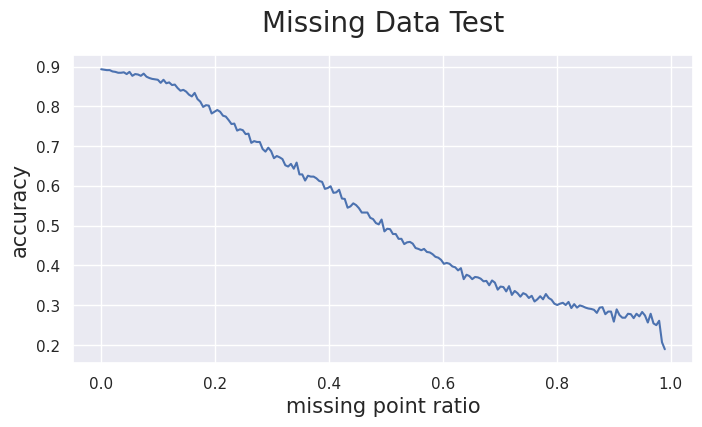

In [40]:
trainer5.missing_data_test()

In [41]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 10,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet_a'
}    

trainer6 = VoxNet_Trainer_a(training_hyperparameters)
trainer6.train()

model DMPVoxNet was choosen
499.25


Train loss: 0.7969061732292175: : 499it [04:18,  1.93it/s]
29it [00:04,  6.75it/s]


epoch:  1 / 50
time: 262.58 seconds
train-loss: 1.11, train-acc-object: 63.84%, train-acc-pose: 50.68%
valid-loss: 1.09, valid-acc-object: 74.56%, train-acc-pose: 68.94%



Train loss: 0.4301237165927887: : 499it [04:16,  1.95it/s]
29it [00:04,  5.84it/s]


epoch:  2 / 50
time: 261.02 seconds
train-loss: 0.58, train-acc-object: 81.87%, train-acc-pose: 71.92%
valid-loss: 0.81, valid-acc-object: 81.72%, train-acc-pose: 72.80%



Train loss: 0.5021102428436279: : 499it [04:13,  1.97it/s]
29it [00:03,  7.74it/s]


epoch:  3 / 50
time: 257.66 seconds
train-loss: 0.45, train-acc-object: 86.53%, train-acc-pose: 76.01%
valid-loss: 0.72, valid-acc-object: 83.81%, train-acc-pose: 75.66%



Train loss: 0.4327799081802368: : 499it [04:15,  1.96it/s]
29it [00:04,  6.93it/s]


epoch:  4 / 50
time: 259.35 seconds
train-loss: 0.39, train-acc-object: 88.42%, train-acc-pose: 77.05%
valid-loss: 0.67, valid-acc-object: 84.47%, train-acc-pose: 77.09%



Train loss: 0.4227202236652374: : 499it [04:14,  1.96it/s]
29it [00:03,  7.48it/s]


epoch:  5 / 50
time: 258.13 seconds
train-loss: 0.35, train-acc-object: 90.27%, train-acc-pose: 78.85%
valid-loss: 0.61, valid-acc-object: 86.23%, train-acc-pose: 78.08%



Train loss: 0.20277726650238037: : 499it [04:13,  1.97it/s]
29it [00:04,  7.23it/s]


epoch:  6 / 50
time: 257.45 seconds
train-loss: 0.33, train-acc-object: 90.92%, train-acc-pose: 79.56%
valid-loss: 0.56, valid-acc-object: 87.33%, train-acc-pose: 76.43%



Train loss: 0.2115342915058136: : 499it [04:09,  2.00it/s]
29it [00:03,  7.62it/s]


epoch:  7 / 50
time: 252.93 seconds
train-loss: 0.30, train-acc-object: 91.79%, train-acc-pose: 80.31%
valid-loss: 0.52, valid-acc-object: 87.00%, train-acc-pose: 75.00%



Train loss: 0.2839648127555847: : 499it [04:06,  2.02it/s]
29it [00:03,  7.89it/s]


epoch:  8 / 50
time: 250.44 seconds
train-loss: 0.27, train-acc-object: 93.03%, train-acc-pose: 81.24%
valid-loss: 0.48, valid-acc-object: 88.55%, train-acc-pose: 79.85%



Train loss: 0.33215224742889404: : 499it [04:05,  2.03it/s]
29it [00:04,  6.68it/s]


epoch:  9 / 50
time: 249.68 seconds
train-loss: 0.25, train-acc-object: 93.67%, train-acc-pose: 81.84%
valid-loss: 0.47, valid-acc-object: 88.22%, train-acc-pose: 79.30%



Train loss: 0.28136149048805237: : 499it [04:04,  2.04it/s]
29it [00:04,  6.28it/s]


epoch: 10 / 50
time: 249.54 seconds
train-loss: 0.24, train-acc-object: 94.03%, train-acc-pose: 81.90%
valid-loss: 0.47, valid-acc-object: 87.22%, train-acc-pose: 79.30%



Train loss: 0.2579731345176697: : 499it [04:08,  2.00it/s]
29it [00:04,  6.41it/s]


epoch: 11 / 50
time: 253.45 seconds
train-loss: 0.24, train-acc-object: 94.24%, train-acc-pose: 82.20%
valid-loss: 0.44, valid-acc-object: 88.55%, train-acc-pose: 80.95%



Train loss: 0.17045778036117554: : 499it [04:07,  2.02it/s]
29it [00:04,  7.15it/s]


epoch: 12 / 50
time: 251.65 seconds
train-loss: 0.23, train-acc-object: 94.37%, train-acc-pose: 82.57%
valid-loss: 0.45, valid-acc-object: 88.11%, train-acc-pose: 78.74%



Train loss: 0.3002470135688782: : 499it [04:05,  2.03it/s]
29it [00:04,  6.30it/s]


epoch: 13 / 50
time: 249.85 seconds
train-loss: 0.22, train-acc-object: 94.81%, train-acc-pose: 82.48%
valid-loss: 0.43, valid-acc-object: 89.21%, train-acc-pose: 79.30%



Train loss: 0.23640021681785583: : 499it [04:04,  2.04it/s]
29it [00:04,  6.66it/s]


epoch: 14 / 50
time: 248.62 seconds
train-loss: 0.22, train-acc-object: 94.92%, train-acc-pose: 82.96%
valid-loss: 0.42, valid-acc-object: 88.66%, train-acc-pose: 80.29%



Train loss: 0.24174821376800537: : 499it [04:03,  2.05it/s]
29it [00:03,  8.13it/s]


epoch: 15 / 50
time: 247.54 seconds
train-loss: 0.20, train-acc-object: 95.55%, train-acc-pose: 83.18%
valid-loss: 0.41, valid-acc-object: 89.32%, train-acc-pose: 79.85%



Train loss: 0.17904618382453918: : 499it [04:04,  2.04it/s]
29it [00:03,  8.13it/s]


epoch: 16 / 50
time: 248.57 seconds
train-loss: 0.20, train-acc-object: 95.59%, train-acc-pose: 83.16%
valid-loss: 0.41, valid-acc-object: 89.21%, train-acc-pose: 80.84%



Train loss: 0.21065998077392578: : 499it [04:03,  2.05it/s]
29it [00:03,  7.63it/s]


epoch: 17 / 50
time: 247.55 seconds
train-loss: 0.20, train-acc-object: 95.73%, train-acc-pose: 83.44%
valid-loss: 0.41, valid-acc-object: 88.77%, train-acc-pose: 80.40%



Train loss: 0.24101953208446503: : 499it [04:01,  2.06it/s]
29it [00:03,  7.73it/s]


epoch: 18 / 50
time: 245.52 seconds
train-loss: 0.20, train-acc-object: 95.76%, train-acc-pose: 83.79%
valid-loss: 0.40, valid-acc-object: 88.55%, train-acc-pose: 80.07%



Train loss: 0.2736222743988037: : 499it [03:59,  2.08it/s]
29it [00:03,  8.39it/s]


epoch: 19 / 50
time: 243.43 seconds
train-loss: 0.19, train-acc-object: 96.00%, train-acc-pose: 83.60%
valid-loss: 0.40, valid-acc-object: 88.99%, train-acc-pose: 79.85%



Train loss: 0.1382368505001068: : 499it [03:59,  2.09it/s]
29it [00:03,  8.26it/s]


epoch: 20 / 50
time: 242.63 seconds
train-loss: 0.19, train-acc-object: 96.10%, train-acc-pose: 83.67%
valid-loss: 0.39, valid-acc-object: 89.76%, train-acc-pose: 79.85%



Train loss: 0.17326480150222778: : 499it [03:58,  2.09it/s]
29it [00:04,  6.85it/s]


epoch: 21 / 50
time: 243.01 seconds
train-loss: 0.19, train-acc-object: 95.98%, train-acc-pose: 84.02%
valid-loss: 0.39, valid-acc-object: 89.10%, train-acc-pose: 81.28%



Train loss: 0.15188045799732208: : 499it [03:57,  2.11it/s]
29it [00:03,  8.61it/s]


epoch: 22 / 50
time: 240.42 seconds
train-loss: 0.18, train-acc-object: 96.29%, train-acc-pose: 84.09%
valid-loss: 0.39, valid-acc-object: 89.54%, train-acc-pose: 80.51%



Train loss: 0.1810106337070465: : 499it [03:56,  2.11it/s]
29it [00:03,  8.83it/s]


epoch: 23 / 50
time: 239.61 seconds
train-loss: 0.18, train-acc-object: 96.32%, train-acc-pose: 84.12%
valid-loss: 0.39, valid-acc-object: 88.77%, train-acc-pose: 80.51%



Train loss: 0.11502659320831299: : 499it [03:56,  2.11it/s]
29it [00:04,  7.12it/s]


epoch: 24 / 50
time: 240.52 seconds
train-loss: 0.18, train-acc-object: 96.45%, train-acc-pose: 83.93%
valid-loss: 0.38, valid-acc-object: 89.32%, train-acc-pose: 79.85%



Train loss: 0.17688237130641937: : 499it [03:56,  2.11it/s]
29it [00:03,  7.78it/s]


epoch: 25 / 50
time: 240.39 seconds
train-loss: 0.18, train-acc-object: 96.48%, train-acc-pose: 84.09%
valid-loss: 0.38, valid-acc-object: 89.32%, train-acc-pose: 80.95%



Train loss: 0.14841943979263306: : 499it [03:55,  2.12it/s]
29it [00:03,  8.87it/s]


epoch: 26 / 50
time: 238.96 seconds
train-loss: 0.17, train-acc-object: 96.62%, train-acc-pose: 84.37%
valid-loss: 0.38, valid-acc-object: 88.88%, train-acc-pose: 80.40%



Train loss: 0.1932717263698578: : 499it [03:54,  2.13it/s]
29it [00:03,  8.82it/s]


epoch: 27 / 50
time: 237.89 seconds
train-loss: 0.18, train-acc-object: 96.63%, train-acc-pose: 84.42%
valid-loss: 0.38, valid-acc-object: 88.99%, train-acc-pose: 80.84%



Train loss: 0.18332265317440033: : 499it [03:58,  2.09it/s]
29it [00:03,  8.75it/s]


epoch: 28 / 50
time: 242.21 seconds
train-loss: 0.17, train-acc-object: 96.76%, train-acc-pose: 84.37%
valid-loss: 0.38, valid-acc-object: 89.21%, train-acc-pose: 81.06%



Train loss: 0.20379577577114105: : 499it [03:54,  2.13it/s]
29it [00:03,  8.73it/s]


epoch: 29 / 50
time: 237.52 seconds
train-loss: 0.17, train-acc-object: 96.78%, train-acc-pose: 84.51%
valid-loss: 0.38, valid-acc-object: 89.32%, train-acc-pose: 81.06%



Train loss: 0.16811951994895935: : 499it [03:58,  2.10it/s]
29it [00:04,  7.04it/s]


epoch: 30 / 50
time: 242.29 seconds
train-loss: 0.17, train-acc-object: 96.77%, train-acc-pose: 84.68%
valid-loss: 0.37, valid-acc-object: 88.77%, train-acc-pose: 80.73%



Train loss: 0.13014036417007446: : 499it [03:54,  2.13it/s]
29it [00:03,  8.43it/s]


epoch: 31 / 50
time: 238.22 seconds
train-loss: 0.17, train-acc-object: 96.81%, train-acc-pose: 84.55%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 80.84%



Train loss: 0.1261354386806488: : 499it [03:53,  2.14it/s]
29it [00:03,  8.80it/s]


epoch: 32 / 50
time: 236.95 seconds
train-loss: 0.17, train-acc-object: 96.81%, train-acc-pose: 84.33%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 81.50%



Train loss: 0.14012059569358826: : 499it [03:52,  2.15it/s]
29it [00:03,  7.72it/s]


epoch: 33 / 50
time: 236.34 seconds
train-loss: 0.17, train-acc-object: 96.81%, train-acc-pose: 84.47%
valid-loss: 0.37, valid-acc-object: 88.66%, train-acc-pose: 81.06%



Train loss: 0.21478845179080963: : 499it [03:51,  2.15it/s]
29it [00:04,  6.78it/s]


epoch: 34 / 50
time: 236.18 seconds
train-loss: 0.17, train-acc-object: 96.88%, train-acc-pose: 84.75%
valid-loss: 0.37, valid-acc-object: 89.32%, train-acc-pose: 80.18%



Train loss: 0.1452580690383911: : 499it [03:52,  2.14it/s]
29it [00:04,  6.79it/s]


epoch: 35 / 50
time: 237.22 seconds
train-loss: 0.17, train-acc-object: 96.79%, train-acc-pose: 84.38%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 80.95%



Train loss: 0.142126202583313: : 499it [03:51,  2.15it/s]
29it [00:04,  6.81it/s]


epoch: 36 / 50
time: 235.84 seconds
train-loss: 0.17, train-acc-object: 96.91%, train-acc-pose: 84.68%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 80.51%



Train loss: 0.13514992594718933: : 499it [03:52,  2.15it/s]
29it [00:04,  7.14it/s]


epoch: 37 / 50
time: 236.19 seconds
train-loss: 0.16, train-acc-object: 97.03%, train-acc-pose: 84.66%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 81.06%



Train loss: 0.1997222602367401: : 499it [03:54,  2.13it/s]
29it [00:04,  6.55it/s]


epoch: 38 / 50
time: 238.55 seconds
train-loss: 0.16, train-acc-object: 96.98%, train-acc-pose: 84.68%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 80.95%



Train loss: 0.11843891441822052: : 499it [03:54,  2.13it/s]
29it [00:04,  6.69it/s]


epoch: 39 / 50
time: 239.06 seconds
train-loss: 0.16, train-acc-object: 97.07%, train-acc-pose: 84.71%
valid-loss: 0.37, valid-acc-object: 88.88%, train-acc-pose: 80.95%



Train loss: 0.14456254243850708: : 499it [03:53,  2.14it/s]
29it [00:04,  6.65it/s]


epoch: 40 / 50
time: 237.49 seconds
train-loss: 0.16, train-acc-object: 97.09%, train-acc-pose: 84.99%
valid-loss: 0.37, valid-acc-object: 89.65%, train-acc-pose: 81.39%



Train loss: 0.18832597136497498: : 499it [03:51,  2.16it/s]
29it [00:04,  7.09it/s]


epoch: 41 / 50
time: 235.57 seconds
train-loss: 0.16, train-acc-object: 96.99%, train-acc-pose: 84.96%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 81.50%



Train loss: 0.10219462215900421: : 499it [03:50,  2.16it/s]
29it [00:03,  9.29it/s]


epoch: 42 / 50
time: 234.14 seconds
train-loss: 0.16, train-acc-object: 96.98%, train-acc-pose: 84.74%
valid-loss: 0.37, valid-acc-object: 88.99%, train-acc-pose: 81.28%



Train loss: 0.10148438811302185: : 499it [03:51,  2.16it/s]
29it [00:03,  9.28it/s]


epoch: 43 / 50
time: 234.45 seconds
train-loss: 0.16, train-acc-object: 97.17%, train-acc-pose: 84.75%
valid-loss: 0.37, valid-acc-object: 89.32%, train-acc-pose: 81.39%



Train loss: 0.2390924096107483: : 499it [03:50,  2.16it/s]
29it [00:03,  9.11it/s]


epoch: 44 / 50
time: 233.96 seconds
train-loss: 0.16, train-acc-object: 97.08%, train-acc-pose: 84.83%
valid-loss: 0.37, valid-acc-object: 89.54%, train-acc-pose: 81.06%



Train loss: 0.15944458544254303: : 499it [03:50,  2.16it/s]
29it [00:04,  6.97it/s]


epoch: 45 / 50
time: 235.06 seconds
train-loss: 0.16, train-acc-object: 96.98%, train-acc-pose: 84.84%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 80.73%



Train loss: 0.21425378322601318: : 499it [03:50,  2.16it/s]
29it [00:03,  7.84it/s]


epoch: 46 / 50
time: 234.68 seconds
train-loss: 0.16, train-acc-object: 97.00%, train-acc-pose: 84.94%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 81.39%



Train loss: 0.17360447347164154: : 499it [03:50,  2.17it/s]
29it [00:03,  9.31it/s]


epoch: 47 / 50
time: 233.49 seconds
train-loss: 0.16, train-acc-object: 97.00%, train-acc-pose: 84.83%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 81.50%



Train loss: 0.20942269265651703: : 499it [03:50,  2.17it/s]
29it [00:03,  9.11it/s]


epoch: 48 / 50
time: 233.57 seconds
train-loss: 0.16, train-acc-object: 97.10%, train-acc-pose: 84.99%
valid-loss: 0.37, valid-acc-object: 89.43%, train-acc-pose: 81.94%



Train loss: 0.2046070545911789: : 499it [03:50,  2.17it/s]
29it [00:03,  7.30it/s]


epoch: 49 / 50
time: 234.35 seconds
train-loss: 0.16, train-acc-object: 97.06%, train-acc-pose: 84.89%
valid-loss: 0.36, valid-acc-object: 89.21%, train-acc-pose: 80.95%



Train loss: 0.1263098567724228: : 499it [03:49,  2.17it/s]
29it [00:03,  8.81it/s]

epoch: 50 / 50
time: 233.05 seconds
train-loss: 0.16, train-acc-object: 97.14%, train-acc-pose: 84.58%
valid-loss: 0.37, valid-acc-object: 89.21%, train-acc-pose: 80.73%



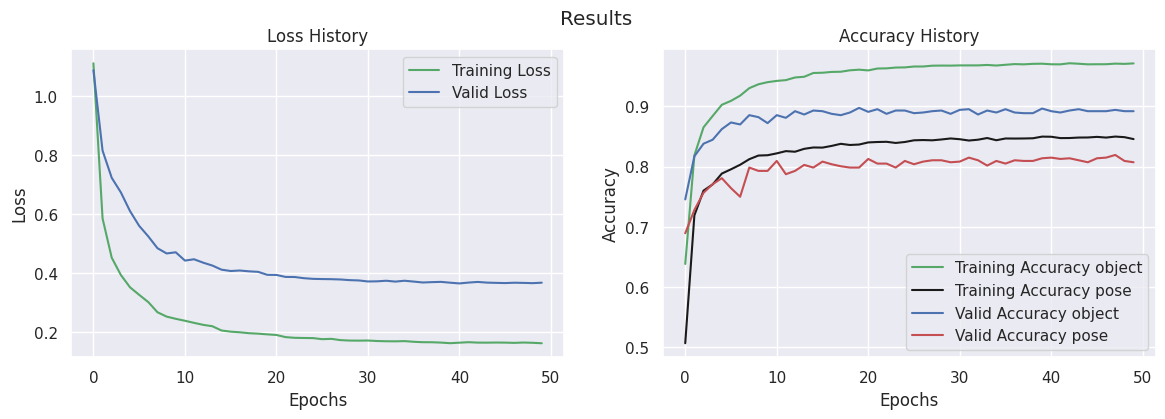

In [42]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 20
with a validation loss of: 0.3931343 and a validation accuracy of: 89.75771069526672


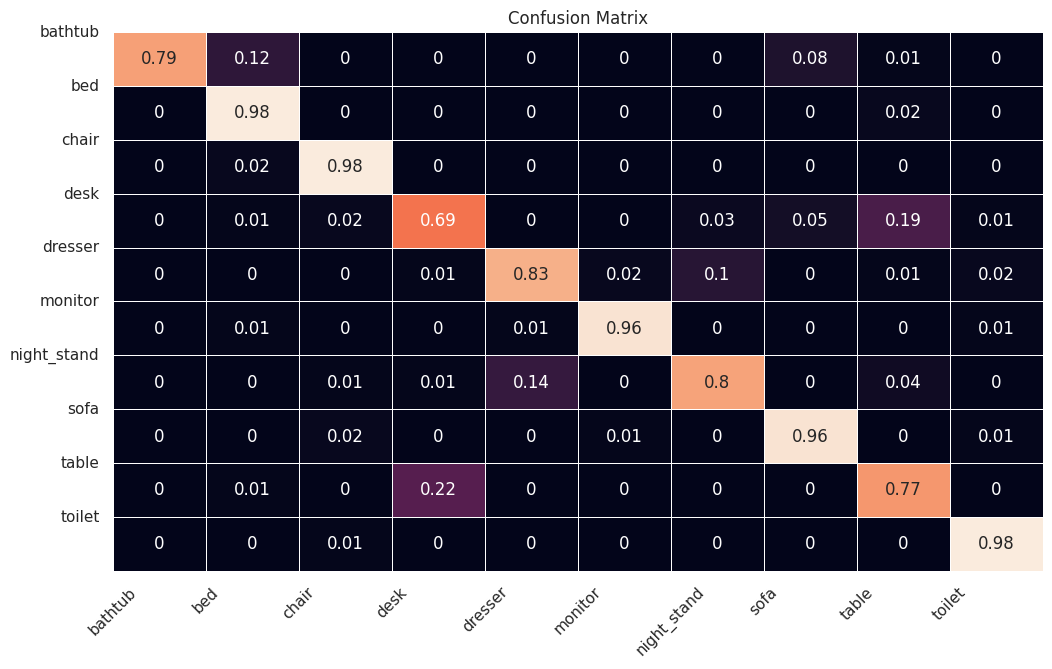

In [43]:
trainer6.generateConfusionMatrix()

best model was trained at epoch: 20
with a validation loss of: 0.3931343 and a validation accuracy of: 89.75771069526672


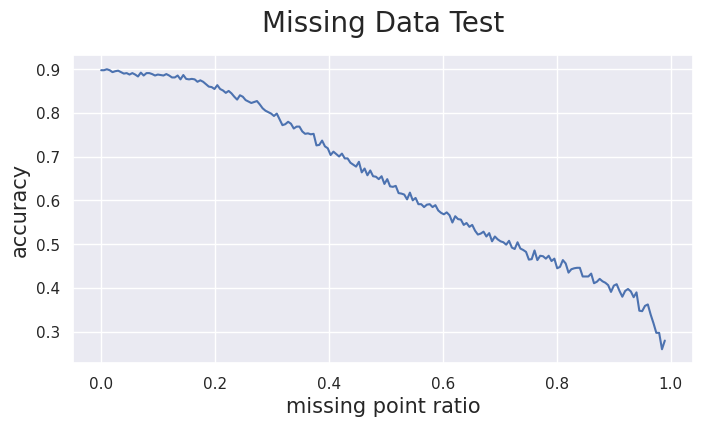

In [44]:
trainer6.missing_data_test()

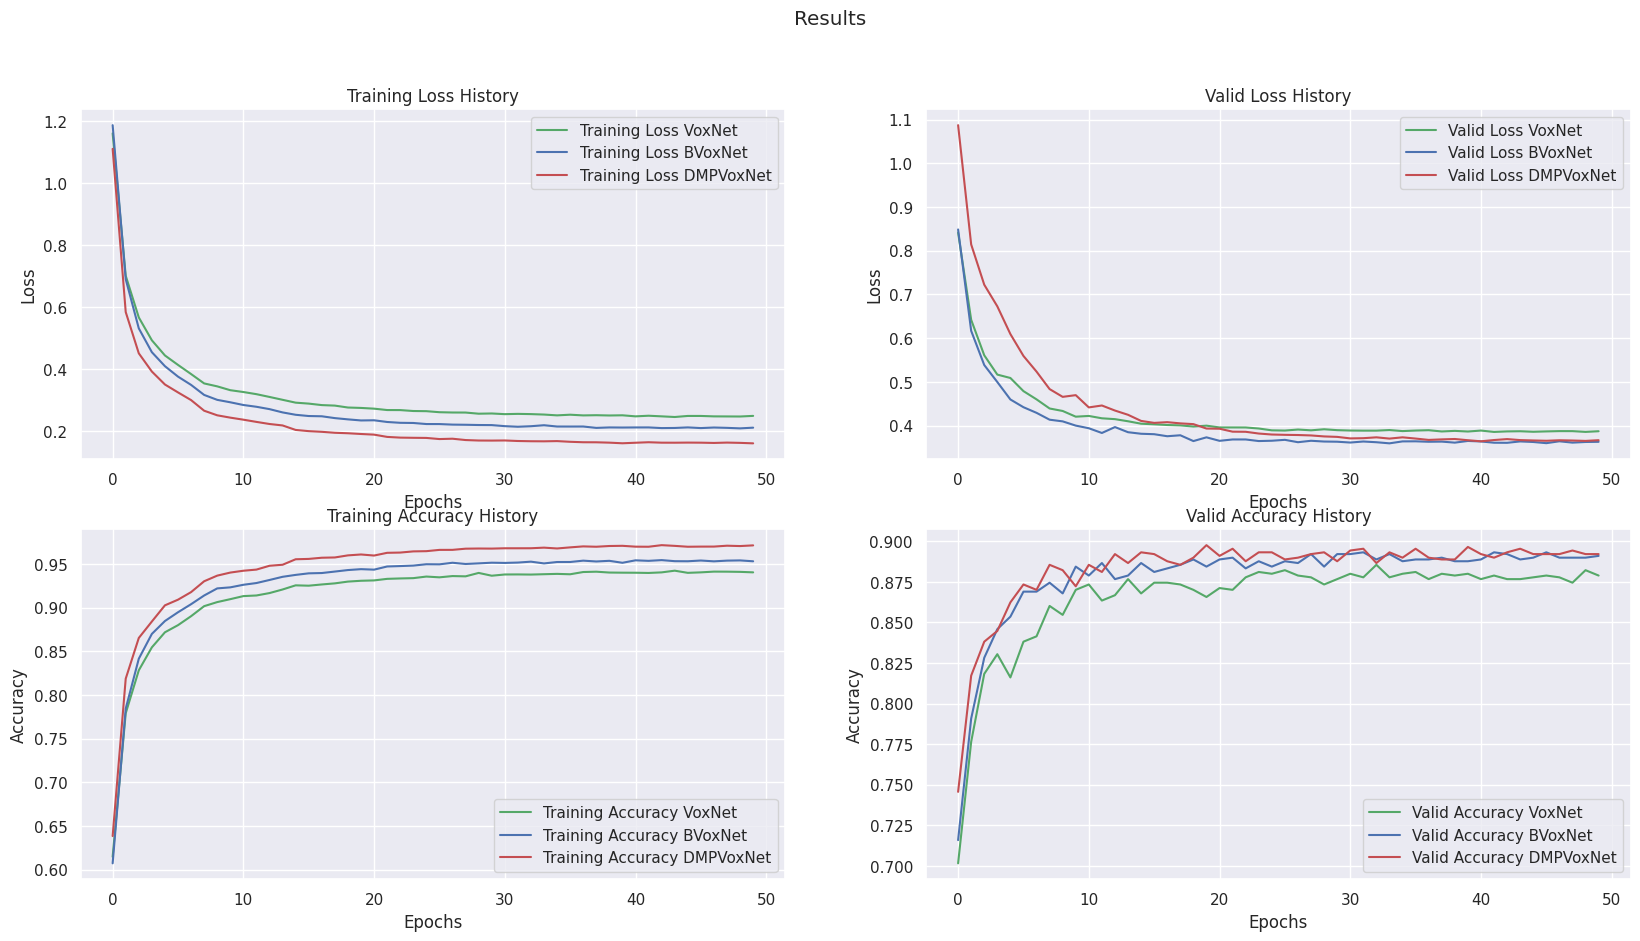

In [45]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

NameError: ignored

# Download and unzip the dataset ModelNet40



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/ModelNet40.zip";

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-19 08:16:39--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-19 08:16:40--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  56.9MB/s    in 53s     

2023-05-19 08:17:32 (37.0 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


  9%|▉         | 46/515 [00:01<00:17, 26.14it/s]<ipython-input-4-c756dd08d0a1>:54: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
 11%|█         | 55/515 [00:01<00:16, 27.74it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 15%|█▍        | 77/515 [00:02<00:20, 21.60it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 22%|██▏       | 113/515 [00:03<00:08, 45.62it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 55%|█████▌    | 284/515 [00:09<00:05, 41.47it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.


 95%|█████████▌| 490/515 [00:16<00:00, 51.32it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.


 15%|█▍        | 130/889 [00:06<00:38, 19.70it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 22%|██▏       | 192/889 [00:08<00:29, 23.28it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 34%|███▎      | 300/889 [00:12<00:18, 32.08it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 93%|█████████▎| 830/889 [00:34<00:03, 19.07it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


 57%|█████▋    | 49/86 [00:01<00:00, 42.67it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.


100%|██████████| 20/20 [00:00<00:00, 30.66it/s]


#VoxNet with Modelnet40

In [ ]:
class VoxelDataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class VoxNet_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset40(train=True)
      self.test_ds = VoxelDataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = VoxNet40()
      os.mkdir('/content/'+str(self.name_model))
      print('model VoxNet40 was choosen')
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)


  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training and validation loss
          train_loss = []                                                        
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()

          #evaluation phase             
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          #total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          #save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      #compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
class VoxNet40(nn.Module):
    def __init__(self):
        super(VoxNet40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('batch4', torch.nn.BatchNorm3d(256)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet40'
}    

trainer8 = VoxNet_Trainer40(training_hyperparameters)
trainer8.train()

model VoxNet40 was choosen
143.75


Train loss: 2.7538280487060547: : 143it [00:38,  3.68it/s]
77it [00:07, 10.00it/s]


epoch:  1 / 50
time: 46.59 seconds
train-loss: 2.63, train-acc-object: 21.63%, train-acc-pose: 17.33%
valid-loss: 2.40, valid-acc-object: 21.40%, train-acc-pose: 23.67%



Train loss: 2.2300562858581543: : 143it [00:39,  3.60it/s]
77it [00:06, 12.81it/s]


epoch:  2 / 50
time: 45.78 seconds
train-loss: 2.31, train-acc-object: 28.85%, train-acc-pose: 21.18%
valid-loss: 2.09, valid-acc-object: 35.12%, train-acc-pose: 28.26%



Train loss: 2.153956890106201: : 143it [00:39,  3.63it/s]
77it [00:06, 11.89it/s]


epoch:  3 / 50
time: 45.86 seconds
train-loss: 2.18, train-acc-object: 32.51%, train-acc-pose: 23.32%
valid-loss: 1.96, valid-acc-object: 40.80%, train-acc-pose: 29.76%



Train loss: 2.2372069358825684: : 143it [00:39,  3.65it/s]
77it [00:07, 10.06it/s]


epoch:  4 / 50
time: 46.85 seconds
train-loss: 2.08, train-acc-object: 35.17%, train-acc-pose: 25.43%
valid-loss: 1.87, valid-acc-object: 36.83%, train-acc-pose: 29.88%



Train loss: 1.7740391492843628: : 143it [00:39,  3.60it/s]
77it [00:06, 12.64it/s]


epoch:  5 / 50
time: 45.87 seconds
train-loss: 2.02, train-acc-object: 36.92%, train-acc-pose: 26.88%
valid-loss: 1.80, valid-acc-object: 40.80%, train-acc-pose: 29.80%



Train loss: 2.132307767868042: : 143it [00:40,  3.50it/s]
77it [00:07, 10.38it/s]


epoch:  6 / 50
time: 48.31 seconds
train-loss: 1.85, train-acc-object: 41.04%, train-acc-pose: 27.56%
valid-loss: 1.63, valid-acc-object: 52.17%, train-acc-pose: 31.34%



Train loss: 1.7768033742904663: : 143it [00:39,  3.59it/s]
77it [00:05, 12.92it/s]


epoch:  7 / 50
time: 45.84 seconds
train-loss: 1.83, train-acc-object: 41.93%, train-acc-pose: 29.28%
valid-loss: 1.55, valid-acc-object: 54.16%, train-acc-pose: 34.06%



Train loss: 1.7392996549606323: : 143it [00:39,  3.59it/s]
77it [00:06, 11.42it/s]


epoch:  8 / 50
time: 46.62 seconds
train-loss: 1.79, train-acc-object: 43.31%, train-acc-pose: 29.70%
valid-loss: 1.58, valid-acc-object: 51.77%, train-acc-pose: 34.06%



Train loss: 1.5446577072143555: : 143it [00:39,  3.62it/s]
77it [00:07, 10.26it/s]


epoch:  9 / 50
time: 46.98 seconds
train-loss: 1.75, train-acc-object: 43.67%, train-acc-pose: 30.27%
valid-loss: 1.50, valid-acc-object: 56.39%, train-acc-pose: 33.54%



Train loss: 1.7017751932144165: : 143it [00:40,  3.57it/s]
77it [00:06, 12.59it/s]


epoch: 10 / 50
time: 46.22 seconds
train-loss: 1.74, train-acc-object: 44.32%, train-acc-pose: 31.09%
valid-loss: 1.52, valid-acc-object: 54.77%, train-acc-pose: 33.86%



Train loss: 1.593015193939209: : 143it [00:40,  3.55it/s]
77it [00:07, 10.21it/s]


epoch: 11 / 50
time: 47.90 seconds
train-loss: 1.66, train-acc-object: 47.24%, train-acc-pose: 31.87%
valid-loss: 1.43, valid-acc-object: 60.90%, train-acc-pose: 36.62%



Train loss: 1.5814288854599: : 143it [00:40,  3.49it/s]
77it [00:06, 12.30it/s]


epoch: 12 / 50
time: 47.28 seconds
train-loss: 1.65, train-acc-object: 47.30%, train-acc-pose: 32.57%
valid-loss: 1.43, valid-acc-object: 59.52%, train-acc-pose: 36.54%



Train loss: 1.4580751657485962: : 143it [00:40,  3.56it/s]
77it [00:07, 10.27it/s]


epoch: 13 / 50
time: 47.66 seconds
train-loss: 1.62, train-acc-object: 48.86%, train-acc-pose: 32.78%
valid-loss: 1.41, valid-acc-object: 59.56%, train-acc-pose: 37.43%



Train loss: 1.7726078033447266: : 143it [00:40,  3.57it/s]
77it [00:06, 12.21it/s]


epoch: 14 / 50
time: 46.43 seconds
train-loss: 1.61, train-acc-object: 49.39%, train-acc-pose: 32.98%
valid-loss: 1.37, valid-acc-object: 63.46%, train-acc-pose: 37.80%



Train loss: 1.8618106842041016: : 143it [00:40,  3.55it/s]
77it [00:07, 10.80it/s]


epoch: 15 / 50
time: 47.44 seconds
train-loss: 1.60, train-acc-object: 49.31%, train-acc-pose: 34.95%
valid-loss: 1.36, valid-acc-object: 61.92%, train-acc-pose: 37.80%



Train loss: 1.4837262630462646: : 143it [00:40,  3.56it/s]
77it [00:07, 10.74it/s]


epoch: 16 / 50
time: 47.32 seconds
train-loss: 1.57, train-acc-object: 50.58%, train-acc-pose: 34.99%
valid-loss: 1.31, valid-acc-object: 64.31%, train-acc-pose: 38.57%



Train loss: 1.5572093725204468: : 143it [00:41,  3.46it/s]
77it [00:09,  7.89it/s]


epoch: 17 / 50
time: 51.16 seconds
train-loss: 1.55, train-acc-object: 50.40%, train-acc-pose: 35.27%
valid-loss: 1.31, valid-acc-object: 66.18%, train-acc-pose: 38.45%



Train loss: 1.720576286315918: : 143it [00:41,  3.43it/s]
77it [00:07, 10.74it/s]


epoch: 18 / 50
time: 48.90 seconds
train-loss: 1.54, train-acc-object: 51.04%, train-acc-pose: 35.19%
valid-loss: 1.32, valid-acc-object: 65.21%, train-acc-pose: 39.42%



Train loss: 1.7399392127990723: : 143it [00:43,  3.31it/s]
77it [00:08,  8.66it/s]


epoch: 19 / 50
time: 52.10 seconds
train-loss: 1.54, train-acc-object: 50.91%, train-acc-pose: 35.50%
valid-loss: 1.32, valid-acc-object: 65.69%, train-acc-pose: 38.94%



Train loss: 1.5587022304534912: : 143it [00:43,  3.30it/s]
77it [00:07, 10.84it/s]


epoch: 20 / 50
time: 50.43 seconds
train-loss: 1.53, train-acc-object: 51.39%, train-acc-pose: 35.89%
valid-loss: 1.29, valid-acc-object: 65.81%, train-acc-pose: 39.38%



Train loss: 1.5400606393814087: : 143it [00:42,  3.36it/s]
77it [00:07,  9.98it/s]


epoch: 21 / 50
time: 50.35 seconds
train-loss: 1.50, train-acc-object: 52.51%, train-acc-pose: 36.96%
valid-loss: 1.29, valid-acc-object: 66.54%, train-acc-pose: 39.67%



Train loss: 1.5557737350463867: : 143it [00:42,  3.38it/s]
77it [00:08,  8.91it/s]


epoch: 22 / 50
time: 50.91 seconds
train-loss: 1.51, train-acc-object: 51.66%, train-acc-pose: 36.60%
valid-loss: 1.28, valid-acc-object: 67.28%, train-acc-pose: 39.46%



Train loss: 1.189796805381775: : 143it [00:43,  3.32it/s]
77it [00:07,  9.97it/s]


epoch: 23 / 50
time: 50.86 seconds
train-loss: 1.50, train-acc-object: 52.68%, train-acc-pose: 37.20%
valid-loss: 1.27, valid-acc-object: 67.11%, train-acc-pose: 40.52%



Train loss: 1.555929183959961: : 21it [00:06,  3.25it/s]


KeyboardInterrupt: ignored

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 43
with a validation loss of: 0.97666 and a validation accuracy of: 78.56273055076599


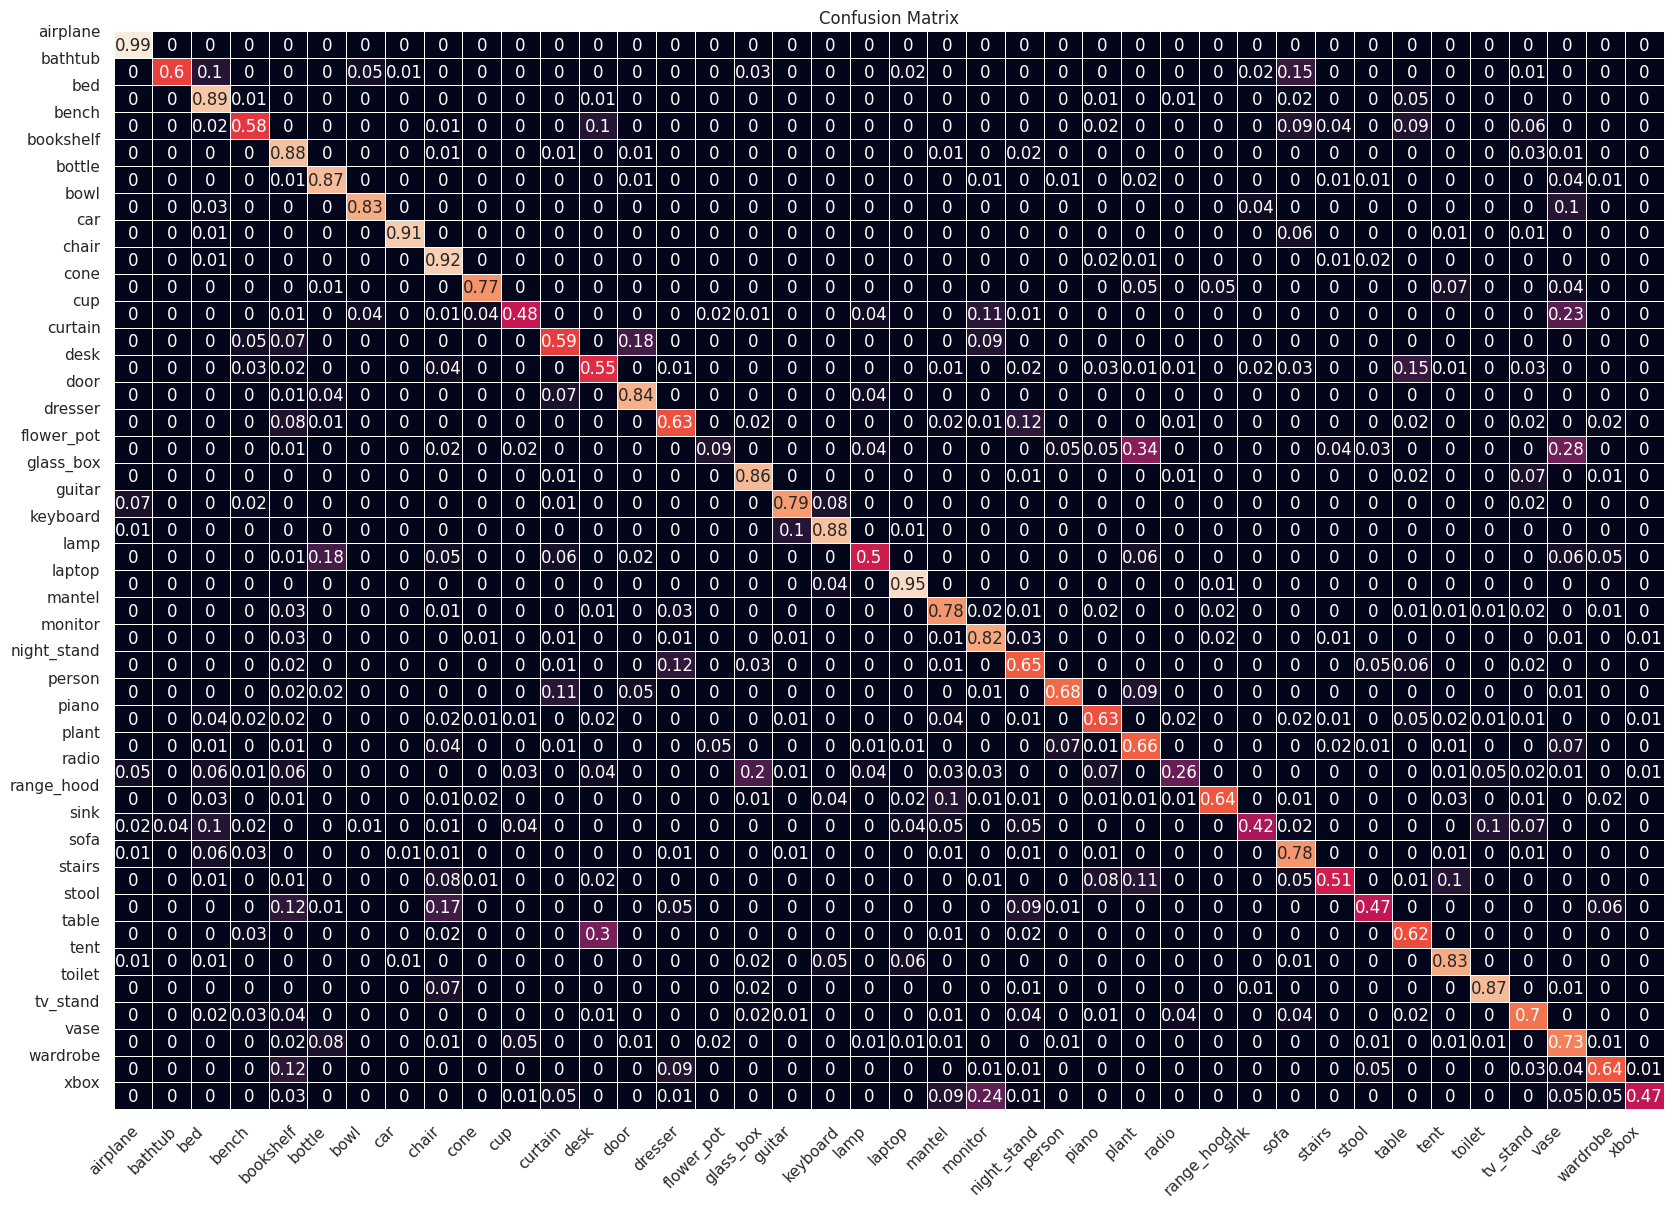

In [ ]:
trainer8.generateConfusionMatrix()